Importiamo tutte le librerie necessarie

In [818]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn import tree, neighbors, svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from scipy import stats
import matplotlib
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline


Leggo il mio file csv

In [736]:
df = pd.read_csv("./METABRIC_RNA_Mutation.csv")
df1 = df

print(df.head())
print(df.describe())
print(df.info())

/var/folders/t7/7795c57s1gg7w0jm6btz_vb00000gn/T/ipykernel_36396/3157117419.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./METABRIC_RNA_Mutation.csv")


   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ... mtap_mut  \
0                 claudin-low     1

Da 0 a 30 abbiamo dati clinici, da 31 a 520 abbiamo dati genetici e da 520 alla fine abbiamo le mutazioni

In [654]:
df[df.columns[31:521]].head(1)

brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn  \
0 -1.399 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348  0.1266 -0.8361   

      nf1  ...  srd5a2  srd5a3     st7    star    tnk2   tulp4  ugt2b15  \
0 -0.8578  ... -0.0194 -1.6345 -0.2142 -0.5698 -1.1741 -1.4779  -0.5954   

   ugt2b17  ugt2b7  pik3ca_mut  
0  -0.8847 -0.3354           0  

[1 rows x 490 columns]

In [646]:
df.columns[520]

'pik3ca_mut'

In [542]:
df1.shape[:]

(1904, 693)

Vediamo i dati mancanti per ogni colonna e la relativa percentuale

In [683]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ["Total_NaN", "Percent_NaN"])
missing_data.head(10) #Mancano solo dati clinici, invece genetici no.

Total_NaN  Percent_NaN
tumor_stage                      501     0.263130
3-gene_classifier_subtype        204     0.107143
primary_tumor_laterality         106     0.055672
neoplasm_histologic_grade         72     0.037815
cellularity                       54     0.028361
mutation_count                    45     0.023634
er_status_measured_by_ihc         30     0.015756
type_of_breast_surgery            22     0.011555
tumor_size                        20     0.010504
cancer_type_detailed              15     0.007878

Text(0.5, 1.0, 'Missing value')

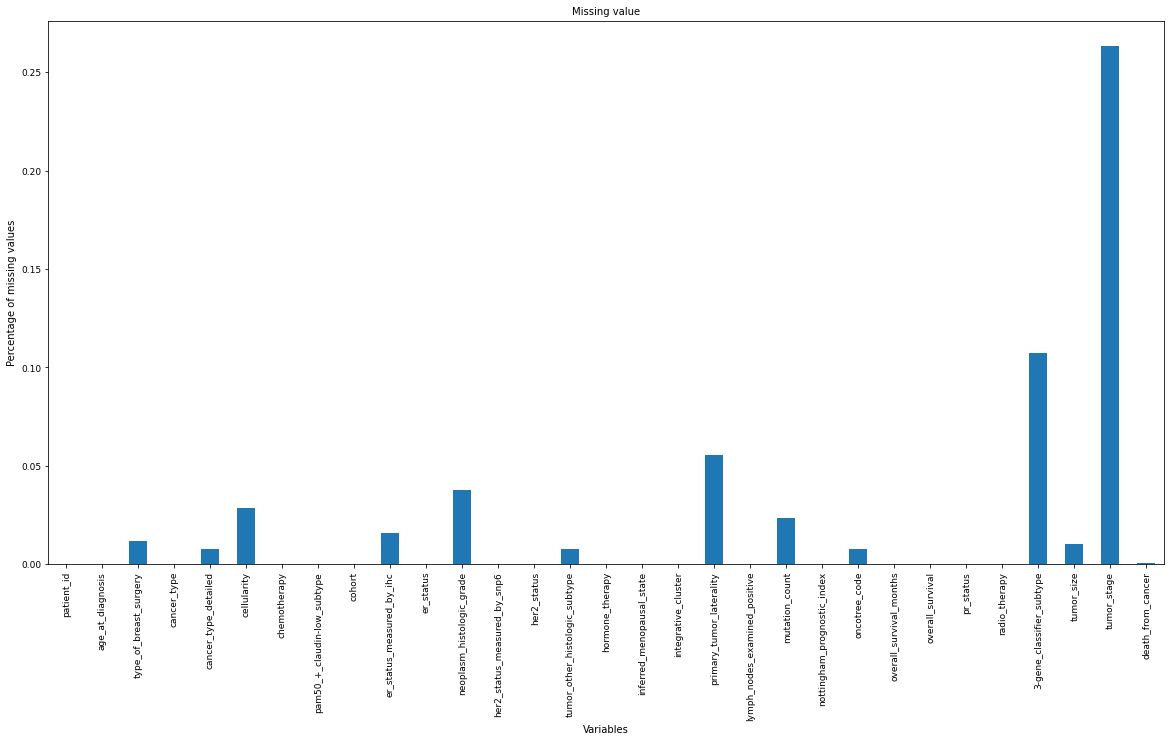

In [544]:
df1 = df.loc[:,'patient_id': 'death_from_cancer']
df1.isnull().mean().plot.bar(figsize=(20,10))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Missing value')

Come si può vedere, i dati clinici hanno alcune categorie in cui sono presenti dei dati mancanti, come per esempio il campo "tumor_stage" con il 26% di valori mancanti.

In [675]:
df[df.columns[0:31]].corr()['overall_survival'].sort_values(ascending = False)

overall_survival                 1.000000
overall_survival_months          0.551656
radio_therapy                    0.081666
hormone_therapy                 -0.003571
chemotherapy                    -0.076449
mutation_count                  -0.128584
neoplasm_histologic_grade       -0.153220
cohort                          -0.153759
patient_id                      -0.155962
age_at_diagnosis                -0.161743
tumor_stage                     -0.227735
tumor_size                      -0.232410
lymph_nodes_examined_positive   -0.247064
nottingham_prognostic_index     -0.277347
Name: overall_survival, dtype: float64

Siccome la correlazione tra tumor stage e overall_survival è bassa, possiamo eliminare la colonna.

In [737]:
#Soffermiamoci solo su i dati delle persone che sono morte per la malattia o sono ancora vive, trascurando quelle che sono morte per altre cause
df = df[df['death_from_cancer'] != 'Died of Other Causes']
df = df.drop('tumor_stage', axis = 1)
#df = df.dropna() #Capire se va bene eliminarli oppure no
#df.drop('death_from_cancer', axis = 1)
df.shape[:]


(1424, 692)

A) Relazione tra dati clinici e risultati.

Estraggo dal dataset solo i dati relativi ai dati clinici

In [685]:
clinical_features_to_drop = df.columns[30:] #mi segno tutte le colonne da eliminare
clinical_df = df.drop(clinical_features_to_drop, axis = 1)
#Con axis =1 indico che devo eliminare delle colonne
#con .drop ottengo un nuovo dataframe (senza modificare quello originale) con tutte le colonne
#(perchè ho usato axis=1 per indicare le colonne) di prima tranne quelle passate come parametro
#se avessi usato axis=0 o default immagino, avrei eliminato delle righe e non delle colonne.
clinical_df.head()

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
0                 claudin-low     1.0                   Positve  ...   
1                        LumA     1.0                   Positve  ...   
2                        LumB     1.0                   Positve  ...   
3                        LumB     1.0                   Positve  ...   
4                        LumB     1.0                   Positve  ...   

  mutation_count  nottingham_prognostic_index oncotree_code  \
0            NaN                        6.044           IDC   
1            2.0                        4.020           IDC   
2            2.0                        4.030           IDC   
3            1.0                        4.050          MDLC   
4            2.0                        6.080          MDLC   

  overall_survival_months overall_survival  pr_status radio_therapy  \
0              140.500000                1   Negative             1   
1               84.633333                1   Positive             1   
2              163.700000                0   Positive             0   
3              164.933333                1   Positive             1   
4               41.366667                0   Positive             1   

  3-gene_classifier_subtype tumor_size  death_from_cancer  
0                 ER-/HER2-       22.0             Living  
1     ER+/HER2- High Prolif       10.0             Living  
2                       NaN       15.0    Died of Disease  
3                       NaN       25.0             Living  
4     ER+/HER2- High Prolif       40.0    Died of Disease  

[5 rows x 30 columns]

Creo una funzione per normalizzare tutti i valori numerici presenti nel dataset clinical_df


In [686]:
def to_standard (df):
    df_numeric = df[df.select_dtypes(include = np.number).columns.to_list()] #creo un nuovo dataframe che contiene solo le colonne numeriche che vado a normalizzare con StandardScaler
    #per ogni feature i-esima calcolo la media e la deviazione standard  e faccio x' = (x -mean i)/stddev i
    ss = StandardScaler()
    std = ss.fit_transform(df_numeric) #viene applicata la trasformazione di standardizzazione ai dati nel DataFrame num_df,
                                   #ottenendo come risultato una matrice numpy contenente i dati standardizzati.
                                   # Questa matrice non ha più l'informazione sugli indici e le colonne del DataFrame originale num_df.
    std_df = pd.DataFrame(std, index = df_numeric.index, columns = df_numeric.columns)
    return std_df

Ora vediamo dei grafici che connettono alcune colonne all'output finale.

Vedere anche progetto https://www.kaggle.com/code/julioam/breast-cancer-survival-analysis

<AxesSubplot:title={'center':'The Distribution of Numerical Attributes after standardization'}, xlabel='value', ylabel='variable'>

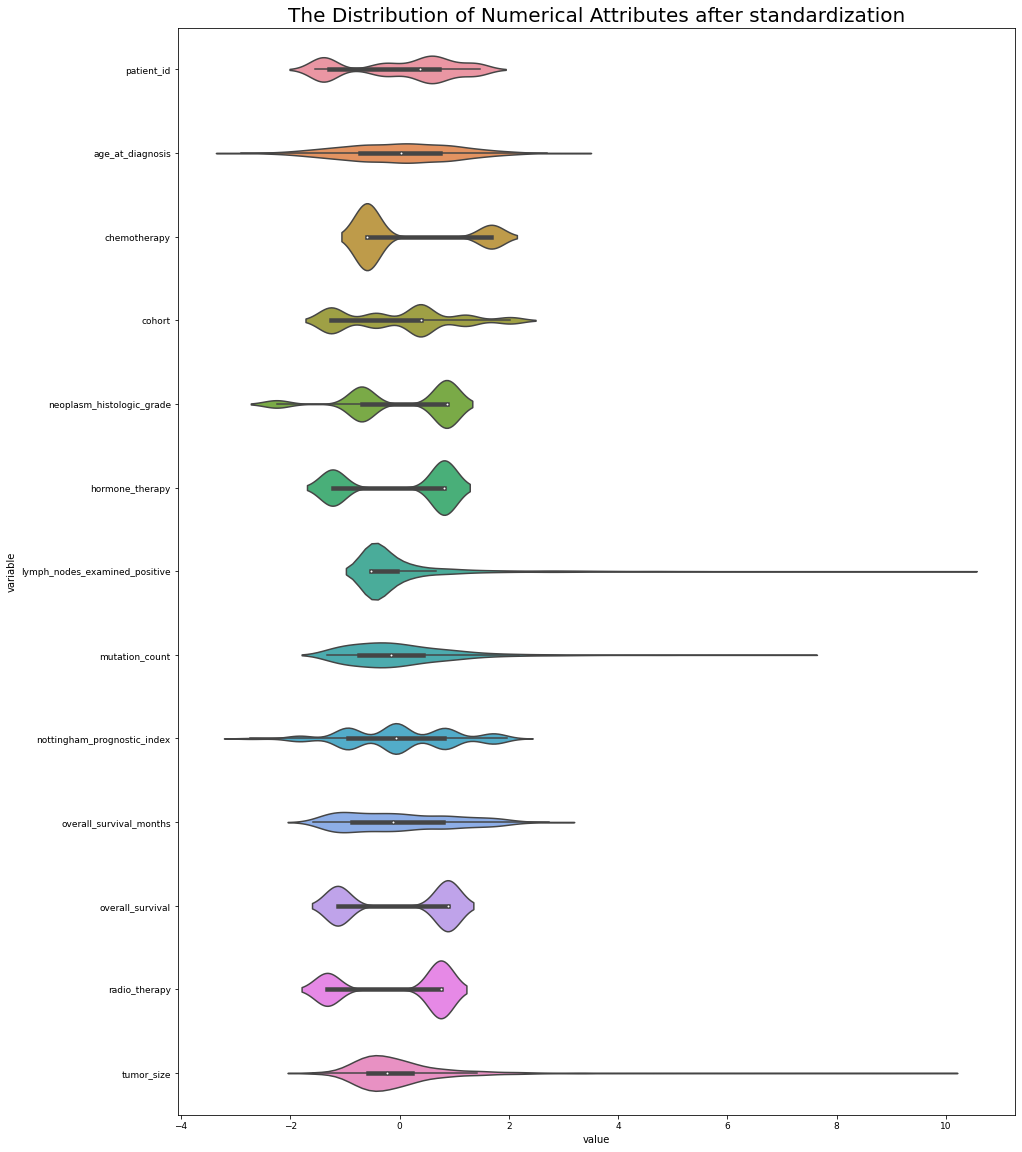

In [687]:
fig = plt.figure(figsize = (15,20))
plt.title('The Distribution of Numerical Attributes after standardization', fontsize = 20)

#sns.violinplot(data = to_standard(clinical_df), x = "value", y = "variable", hue="smoker")
sns.violinplot(y = "variable", x = "value", data = pd.melt(to_standard(clinical_df)))



/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

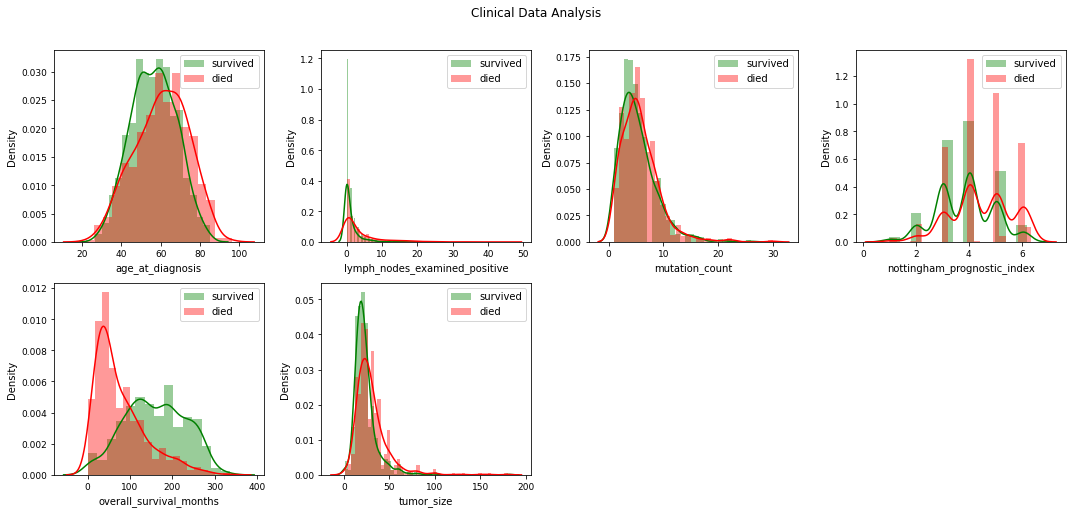

In [688]:
grafico = plt.figure(figsize = (15, 20))
#crea una nuova figura vuota utilizzando la libreria Matplotlib.
#L'argomento figsize specifica le dimensioni della figura in pollici (larghezza, altezza). Nell'esempio fornito, la figura viene impostata su una larghezza di 20 pollici e un'altezza di 15 pollici.
#Assegnando il risultato della chiamata plt.figure() alla variabile grafico, è possibile fare riferimento alla figura in seguito per aggiungere subplot o personalizzare la sua formattazione.
#Una volta creata la figura, è possibile aggiungere subplot, grafici o visualizzazioni utilizzando i metodi e le funzioni forniti da Matplotlib o altre librerie come Seaborn.

j = 0
num_clinical_columns = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
for i in clinical_df[num_clinical_columns].columns:
    #In sintesi, clinical_df[num_clinical_columns] restituisce un DataFrame con le colonne specificate,
    # mentre clinical_df[num_clinical_columns].columns restituisce un oggetto Index contenente i nomi
    # delle colonne del DataFrame risultante. Potevo usare direttamente num_clinical_columns.
    plt.subplot(6, 4, j+1) #perchè la numerazione inizia da 1
    # Una griglia di subplot è un layout organizzato in una griglia di celle,
    # ognuna delle quali può contenere un grafico o una visualizzazione separata.
    # Ad esempio, una griglia di subplot può essere composta da 2 righe e 2 colonne,
    # formando una griglia di 4 celle. Ogni cella può essere considerata come un subplot
    # indipendente in cui è possibile disegnare un grafico separato. Nel nostro caso 6 righe e 4 colonne,
    # 6 x 4 = 24 subplot indipendenti. j (terzo parametro) indica la posizione all'interno della griglia. Con il
    # e aumentando j praticamente ogni nuovo grafico si troverà a fianco del precedente, nella nuova posizione.
    j += 1
    sns.distplot(clinical_df[i] [clinical_df['overall_survival']==1], color = 'g', label = 'survived')
    # crea un grafico a distribuzione della variabile clinical_df[i] per i casi in cui la colonna 'overall_survival'
    # del DataFrame clinical_df è uguale a 1 (indicando i casi di sopravvivenza).
    sns.distplot(clinical_df[i] [clinical_df['overall_survival']==0], color='r', label = 'died')
    plt.legend(loc = 'best')
    #Idem ma per i casi di decesso
    grafico.suptitle('Clinical Data Analysis')

grafico.tight_layout() # viene utilizzata per migliorare la disposizione dei subplot all'interno di una figura, in modo che siano distribuiti in modo uniforme e che non si sovrappongano.

grafico.subplots_adjust(top=0.95) #viene utilizzata per regolare i margini superiori della figura, consentendo di spostare verso il basso l'area di disegno dei subplot.

plt.show()
#Il collegamento tra fig o 'grafico'(nel mio caso) e i subplot avviene in modo implicito attraverso la sequenza di comandi che
#  utilizzano la libreria Matplotlib. Quando si crea un nuovo subplot con plt.subplot(),
# il subplot viene automaticamente aggiunto alla figura 'variabile' grafico in questo caso.
# Inoltre, tutte le operazioni di tracciamento dei grafici, come sns.distplot(),
# vengono eseguite all'interno del contesto della figura 'grafico'.
# In sostanza, la figura 'grafico' o fig rappresenta il contenitore principale dei subplot
# creati con plt.subplot(), anche se non viene fatto un collegamento esplicito
#  nel codice. Questo è il comportamento predefinito di Matplotlib quando si
# lavora con una singola figura.


Età alla diagnosi

I pazienti sopravvissuti hanno una distribuzione bimodale
I pazienti deceduti hanno lasciato una distribuzione distorta
Linfonodi esaminati positivi: sia i pazienti sopravvissuti che quelli deceduti presentano una distribuzione asimmetrica a destra

Conteggio delle mutazioni: sia i pazienti sopravvissuti che quelli morti hanno una distribuzione distorta a destra

Indice prognostico di Nottingham: sia i pazienti sopravvissuti che quelli deceduti hanno una distribuzione multimodale

Mesi di sopravvivenza globale

I pazienti sopravvissuti hanno una distribuzione bimodale
I pazienti deceduti hanno una distribuzione distorta a destra
Dimensioni del tumore: sia i pazienti sopravvissuti che quelli deceduti hanno una distribuzione distorta a destra

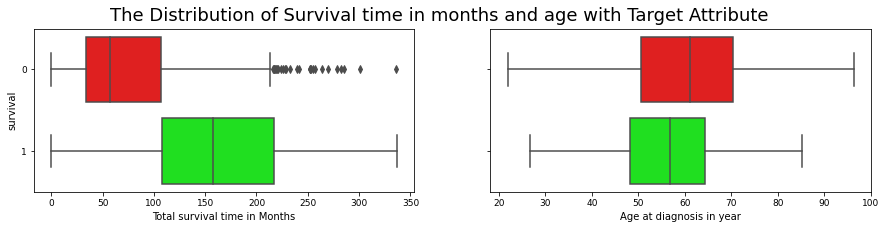

In [689]:
#La differenza principale tra "plt.subplots" e "plt.subplot" è che "plt.subplots" crea una griglia di subplot
# in una singola chiamata, restituendo sia la figura che gli assi dei subplot,
# mentre "plt.subplot" crea un singolo subplot in una chiamata, restituendo solo gli assi del subplot.
# Utilizzando "plt.subplots", è possibile accedere agli assi dei subplot individuandoli tramite l'indice nell'elenco "ax".
# Ad esempio, "ax[0]" rappresenta il primo subplot nella griglia e "ax[1]" rappresenta il secondo subplot.

fig, ax = plt.subplots(ncols = 2, figsize = (15,3), sharey = True)
#crea una figura con due assi, disposti in una griglia con due colonne (ncols=2) e una riga.
# La dimensione totale della figura è impostata su (15, 3) utilizzando il parametro figsize,
#che specifica la larghezza e l'altezza della figura in pollici.
# Inoltre, il parametro sharey=True viene utilizzato per condividere lo stesso asse y tra i due assi,
# il che significa che entrambi gli assi avranno la stessa scala sull'asse y.Il risultato di questo codice
# è una figura con due assi, pronti per essere utilizzati per disegnare grafici.
#Qui utilizzo il primo asse ovvero ax[0]
two_colors = ["#FF0000", "#00FF00"]
sns.boxplot(x = 'overall_survival_months', y = 'overall_survival', orient = 'h', data = clinical_df, ax = ax[0], palette = two_colors)
#Qui utilizzo il secondo asse ovvero ax[1]
sns.boxplot(x = 'age_at_diagnosis', y = 'overall_survival', orient = 'h', data = clinical_df, ax = ax[1], palette = two_colors)

fig.suptitle('The Distribution of Survival time in months and age with Target Attribute', fontsize = 18)

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at diagnosis in year')
ax[1].set_ylabel('')

plt.show()
#Per confrontare le due classi di pazienti che sono sopravvissuti e i pazienti che non lo hanno fatto,
# possiamo vedere la differenza tra le due distribuzioni nella colonna 'age_at_diagnosis', in quanto i pazienti
# che erano più giovani al momento della diagnosi di cancro al seno avevano maggiori probabilità di sopravvivere.
#Qui possiamo notare come, chi muore per la malattia di solito muore relativamente subito e non dopo vari mesi.

#three_colors = ["#00FF00", "#FF0000", "#0000FF"]

Text(0, 0.5, 'Sopravvissuti')

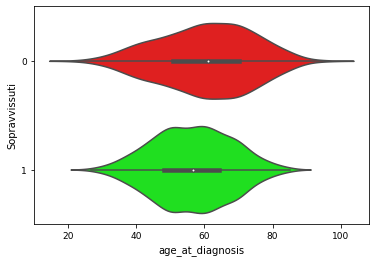

In [691]:
#Sopravvivenza o no in base all'età
sns.violinplot(x = 'age_at_diagnosis', y = 'overall_survival', data = clinical_df, palette = two_colors, orient = 'h')
plt.ylabel("Sopravvissuti")

<AxesSubplot:xlabel='tumor_size', ylabel='overall_survival'>

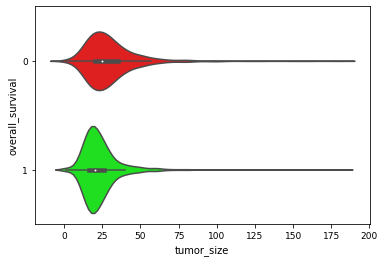

In [692]:
#Sopravvivenza o no in base al diametro del tumore
sns.violinplot(x = 'tumor_size', y = 'overall_survival', orient = 'h', data = clinical_df, palette = two_colors)

Faccio dei sottinsiemi che mi serviranno per i grafici


In [693]:
died = clinical_df[clinical_df['overall_survival']==0]
#clinical_df[clinical_df['overall_survival']==0]:
#Questa espressione viene utilizzata per filtrare il DataFrame clinical_df e
#restituire solo le righe in cui la colonna 'overall_survival' ha il valore 0.
# Quindi, l'output sarà un DataFrame contenente solo le righe che soddisfano
#la condizione.
#clinical_df['overall_survival']==0: Questa espressione viene utilizzata per creare
# una maschera booleana che indica se ciascun elemento della colonna
#'overall_survival' è uguale a 0 o no. L'output sarà una serie di valori booleani,
#con True corrispondente agli elementi che soddisfano la condizione e False
#corrispondente agli elementi che non la soddisfano.

survived = clinical_df[clinical_df['overall_survival']==1]

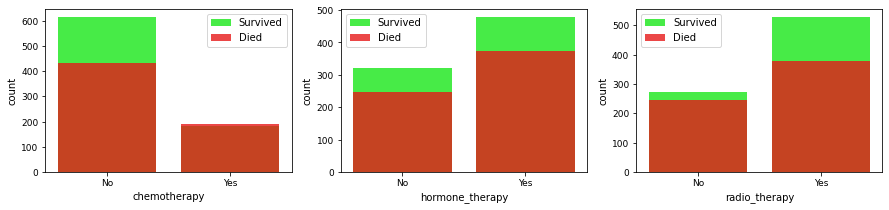

In [694]:
fig, ax = plt.subplots(ncols = 3, figsize= (15,3))
sns.countplot(x = survived['chemotherapy'], color = two_colors[1], label = 'Survived', ax = ax[0], saturation = 0.80, alpha = 0.8)
sns.countplot(x = died['chemotherapy'], color = two_colors[0], label = 'Died', ax = ax[0], saturation = 0.80, alpha = 0.8)
ax[0].set(xticklabels=['No','Yes'])
ax[0].legend()

sns.countplot(x = survived['hormone_therapy'], color = two_colors[1], label='Survived', ax=ax[1], saturation=0.80, alpha = 0.8)
sns.countplot(x = died['hormone_therapy'], color = two_colors[0], label='Died', ax=ax[1], saturation=0.80, alpha = 0.8)
ax[1].set(xticklabels=['No','Yes'])
ax[1].legend()

sns.countplot(x = survived['radio_therapy'], color = two_colors[1], label='Survived', ax=ax[2], saturation=0.80, alpha = 0.8)
sns.countplot(x = died['radio_therapy'], color = two_colors[0], label='Died', ax=ax[2], saturation=0.80, alpha = 0.8)
ax[2].set(xticklabels=['No','Yes'])
ax[2].legend()

plt.show()


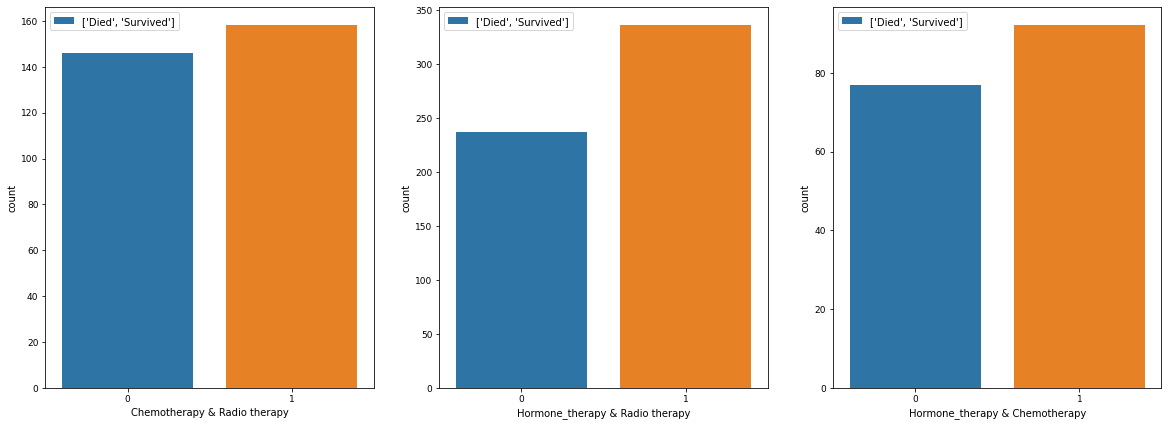

In [695]:
#Di chi ha fatto sia chemio che radio
fig, ax = plt.subplots(ncols = 3, figsize = (20,7))
morti_con_2 = clinical_df[(clinical_df['chemotherapy'] == True) & (clinical_df['radio_therapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[0])
ax[0].legend()
ax[0].set_xlabel('Chemotherapy & Radio therapy')

morti_con_2 = clinical_df[(clinical_df['hormone_therapy'] == True) & (clinical_df['radio_therapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[1])
ax[1].legend()
ax[1].set_xlabel('Hormone_therapy & Radio therapy')

morti_con_2 = clinical_df[(clinical_df['hormone_therapy'] == True) & (clinical_df['chemotherapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[2])
ax[2].legend()
ax[2].set_xlabel('Hormone_therapy & Chemotherapy')

plt.show()




Chemotherapy treatment

The difference between died class and survived class is large for patient with chemotherapy compared to patients without chemotherapy
Patients in died class without chemotherapy is very high, more than 800. Meanwhile, patients in died class with chemotherapy is not so high, a little over 200
Hormonal therapy

The difference between died class and survived class is quite large for patient with hormonal therapy compared to patients without hormonal therapy
Patients in died class with chemotherapy is quite high, a little bit under 700. Patients in died class with chemotherapy is not so high, a little over 400
Radio therapy

The difference between died class and survived class is quite large for patient with radio therapy compared to patients without radio therapy
Number of patients in died class both with radio therapy and without radio therapy is the highest compared to other therapy method

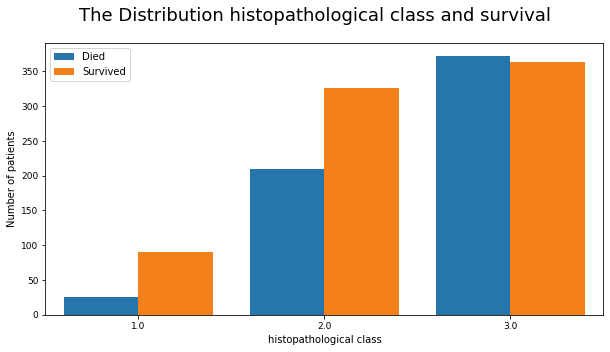

In [696]:
fig, ax = plt.subplots( figsize=(10,5))
fig.suptitle('The Distribution histopathological class and survival', fontsize = 18)

sns.countplot(x='neoplasm_histologic_grade', hue='overall_survival' ,data = clinical_df, ax=ax, saturation=0.90)
ax.legend([ 'Died', 'Survived'])

ax.set_xlabel('histopathological class')
ax.set_ylabel('Number of patients')

plt.show()

The patient in died class is always higher than in survived class except for class 1.0
The difference of number of patients both died and survived class for class 1.0 is high compared to other class

CORRELAZIONE TRA ATTRIBUTI CLINICI

Nel gruppo di denominazione del tipo di cancro, "tumor_other_histologic_subtype", "oncotree_code", "cancer_type" e "cancer_type_detailed" presentano diversi nomi di tipo di cancro. Queste variabili presentano informazioni ridondanti e una potrebbe essere utilizzata nel modello. Diverse variabili ridondanti potrebbero anche essere trovate nel gruppo di informazioni sul tumore. Le variabili "er_status" e "her2_status" presentano le stesse informazioni rispetivamente con "erstatusmeasuredbyihc" e "her2statusmeasuredbysnp6". Inoltre, "X3.gene_classifier_subtype" presenta "her2_status" e "er_status" in un altro modo e non contiene nuove informazioni.

Make overall_survival dataset by removing overall_survival_months and death_from_cancer, which are too similar to overall_survival to be useful.

Rimuovi cancer_type poiché è tutto cancro al seno.



La funzione pd.get_dummies() del modulo pandas viene utilizzata per eseguire la codifica one-hot delle variabili categoriche presenti in un DataFrame.

La codifica one-hot trasforma le variabili categoriche in una rappresentazione numerica binaria. Crea nuove colonne nel DataFrame, corrispondenti alle categorie uniche della variabile categorica, e assegna un valore di 1 nella colonna corrispondente alla categoria effettiva, mentre assegna un valore di 0 nelle altre colonne.
Esempio: abbiamo un DataFrame con una colonna chiamata "Colore" contenente categorie come "Rosso", "Blu" e "Verde". Utilizzando pd.get_dummies(),
-> pd.get_dummies(df, columns=['Colore'])
abbiamo applicato la codifica one-hot alla colonna "Colore". Ciò ha generato tre nuove colonne nel DataFrame risultante: "Colore_Rosso", "Colore_Blu" e "Colore_Verde". Ogni riga del DataFrame ha un valore di 1 nella colonna corrispondente alla categoria effettiva e 0 nelle altre colonne.

La funzione pd.get_dummies() offre anche opzioni per specificare il prefisso delle nuove colonne, gestire valori mancanti, escludere una categoria di riferimento e altro ancora. Queste opzioni possono essere passate come argomenti aggiuntivi alla funzione per personalizzare il comportamento della codifica one-hot.

La codifica one-hot è spesso utilizzata come preparazione dei dati per algoritmi di machine learning che richiedono input numerici. Consente di rappresentare in modo adeguato le variabili categoriche nel processo di addestramento dei modelli senza assegnare una relazione ordinale ai valori delle categorie.

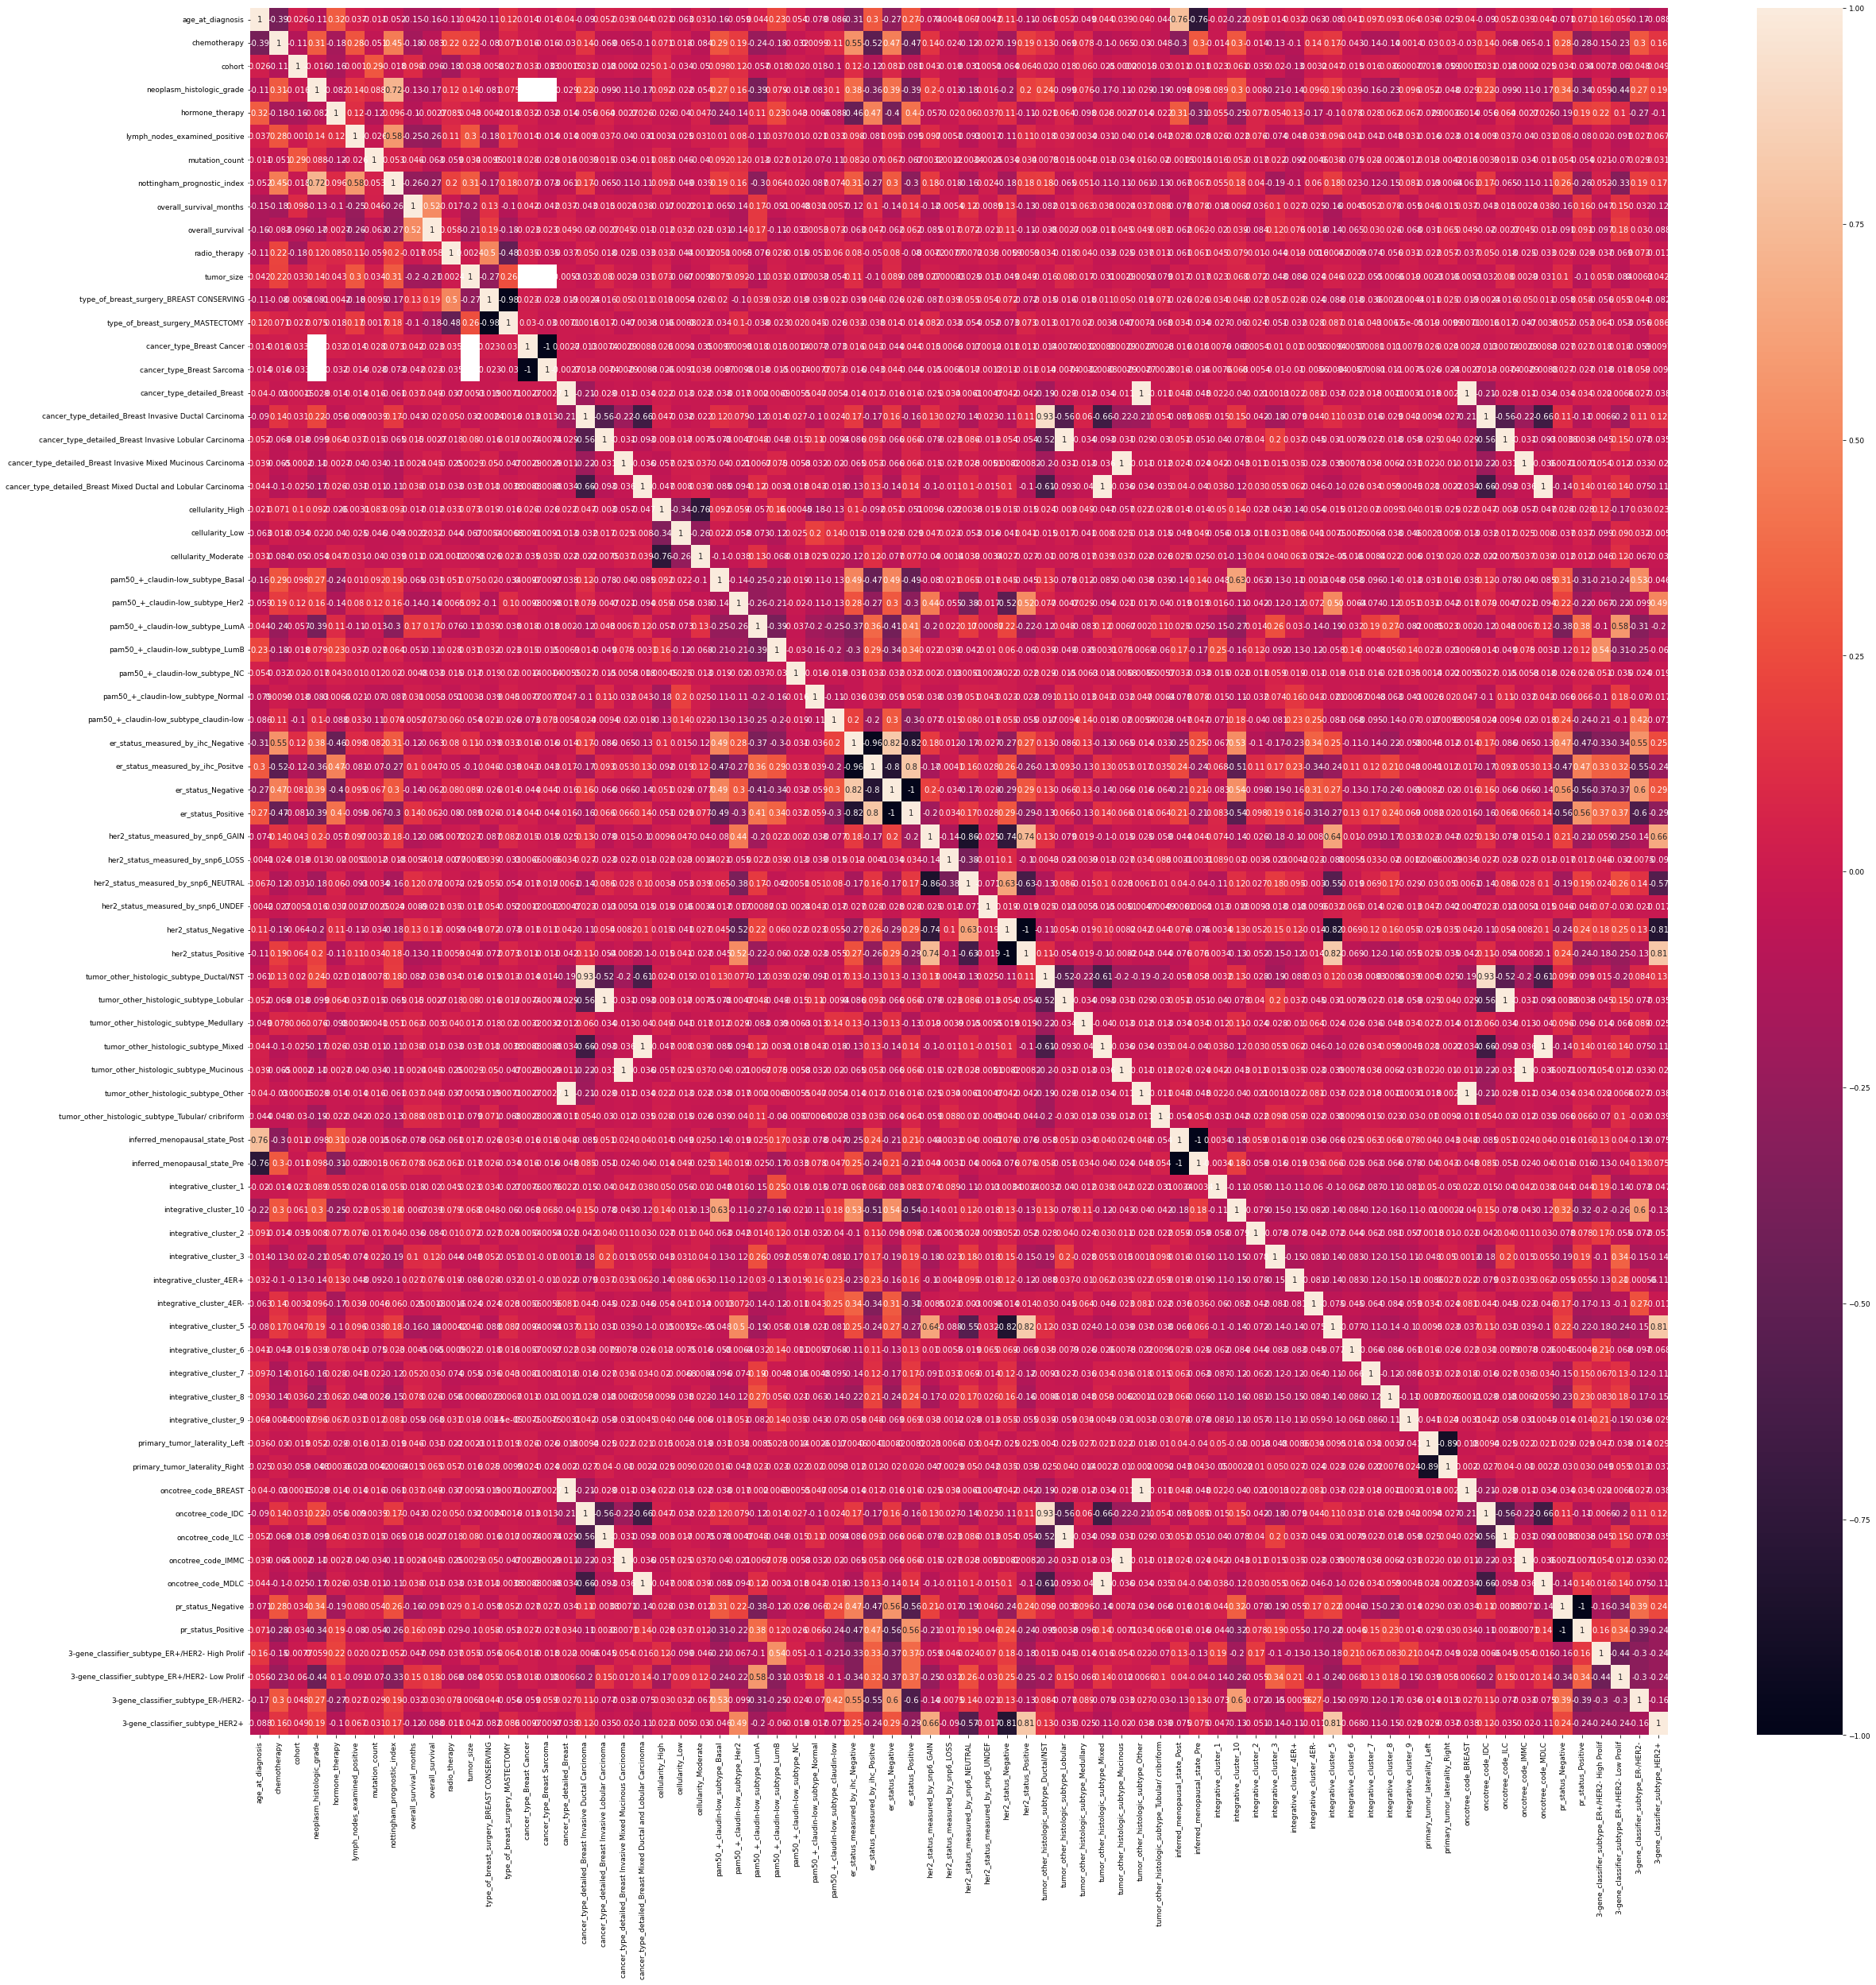

In [697]:
#Inizio eliminando patient_id che non mi serve
plt.figure(figsize = (40,40))
data = clinical_df.drop('patient_id', axis = 1)
data = data.drop('death_from_cancer', axis = 1)

#Inizio considerando le colonne non numeriche e quindi categoriche
nomi_colonne_da_trasformare = data.select_dtypes(include = ['object']).columns.to_list()
data_for_matrix = pd.get_dummies(data = data, columns=nomi_colonne_da_trasformare)
sns.heatmap(data = data_for_matrix.corr(), annot=True)
plt.show()


In [698]:
corr1 = data_for_matrix.corr()
correlazione = np.argsort(-corr1.corr().values, axis=1)
corrValue = corr1.apply(lambda row: row.nlargest(2).values[-1],axis=1)
dfClinicalData = pd.DataFrame({'Correlated Clinical_data': corr1.columns[correlazione[1]], 'Pearson Correlation': corrValue}, index=corr1.index)
print(dfClinicalData.head(5))

                                     Correlated Clinical_data  \
age_at_diagnosis                                 chemotherapy   
chemotherapy               er_status_measured_by_ihc_Negative   
cohort                                     er_status_Negative   
neoplasm_histologic_grade           neoplasm_histologic_grade   
hormone_therapy                   nottingham_prognostic_index   

                           Pearson Correlation  
age_at_diagnosis                      0.761939  
chemotherapy                          0.548029  
cohort                                0.291795  
neoplasm_histologic_grade             0.715072  
hormone_therapy                       0.474795  


In [699]:
#Abbiamo varie correlazioni. Per esempio:

data_for_matrix.corr()['overall_survival'].sort_values(ascending = False)
#data_for_matrix.corr()['death_from_cancer_Died of Disease'].sort_values(ascending = False)


overall_survival                                  1.000000
overall_survival_months                           0.520341
type_of_breast_surgery_BREAST CONSERVING          0.187339
3-gene_classifier_subtype_ER+/HER2- Low Prolif    0.179829
pam50_+_claudin-low_subtype_LumA                  0.166682
                                                    ...   
neoplasm_histologic_grade                        -0.170745
type_of_breast_surgery_MASTECTOMY                -0.183868
tumor_size                                       -0.210409
lymph_nodes_examined_positive                    -0.258164
nottingham_prognostic_index                      -0.273797
Name: overall_survival, Length: 74, dtype: float64

In [700]:
overvall_survival_correlation = pd.DataFrame(data = data_for_matrix.corr()['overall_survival'].sort_values(ascending = False) )
overvall_survival_correlation

overall_survival
overall_survival                                        1.000000
overall_survival_months                                 0.520341
type_of_breast_surgery_BREAST CONSERVING                0.187339
3-gene_classifier_subtype_ER+/HER2- Low Prolif          0.179829
pam50_+_claudin-low_subtype_LumA                        0.166682
...                                                          ...
neoplasm_histologic_grade                              -0.170745
type_of_breast_surgery_MASTECTOMY                      -0.183868
tumor_size                                             -0.210409
lymph_nodes_examined_positive                          -0.258164
nottingham_prognostic_index                            -0.273797

[74 rows x 1 columns]

In [701]:
#statistics for the no treatment group and comparison with the baseline
no_treatment = clinical_df[(clinical_df['chemotherapy']==0) & (clinical_df['hormone_therapy']==0) & (clinical_df['radio_therapy']==0)]
print("Number of patients who had no treatment: " , no_treatment.shape[0])
print("Proportion of survival with no treatment: " , ("%.3f" %np.mean(no_treatment["overall_survival"])))
print("Baseline proportion of survival in all groups: ", ("%.3f" %np.mean(df["overall_survival"])))

#The proportion of survival with no treatment is quite close to the baseline proportion of survival in all group

Number of patients who had no treatment:  192
Proportion of survival with no treatment:  0.573
Baseline proportion of survival in all groups:  0.562


In [738]:
#What the average patient looks like
print("Mean of age : " + "%.3f" %np.mean(clinical_df['age_at_diagnosis']))
print("Most occurring histopathological type :", int(stats.mode(clinical_df['neoplasm_histologic_grade'])[0]))
print("Mean of tumour diameter : " + "%.3f" %np.mean(clinical_df['tumor_size']))
print("Probability of survival : "+ "%.3f" %(clinical_df["overall_survival"].value_counts()/clinical_df["overall_survival"].count()).iloc[1])

Mean of age : 58.214
Most occurring histopathological type : 3
Mean of tumour diameter : 26.288
Probability of survival : 0.438


A) Classification with only clinical attributes¶


In [845]:
#L'argomento dummy_na=True nel metodo pd.get_dummies() indica se includere una colonna addizionale
# per rappresentare i valori mancanti (NaN) nelle variabili categoriche durante la codifica one-hot.

data = clinical_df.drop('death_from_cancer', axis = 1)
columns_object = data.select_dtypes(include = ['object']).columns.to_list()
dataset = pd.get_dummies(data.drop('patient_id',axis=1 ), columns = columns_object, dummy_na = False)
dataset.dropna(inplace = True)
dataset.shape[:]

#dataset = to_standard(dataset)

X = dataset.drop(['overall_survival'], axis = 1)
y = dataset['overall_survival']

#Il parametro stratify nel metodo train_test_split viene utilizzato per
#garantire che la distribuzione delle classi target sia mantenuta nelle
#suddivisioni tra dati di addestramento e dati di test.
#Quando si imposta stratify=y, il metodo train_test_split assicura che
#la proporzione delle classi target all'interno di y sia preservata sia nel
# set di addestramento che nel set di test. In altre parole, se ci sono
#classi sbilanciate nel tuo dataset, l'impostazione di stratify=y assicurerà
# che i dati di addestramento e di test abbiano una distribuzione simile delle classi.

X_train, X_test, y_train, y_test = train_test_split(to_standard(X),y, stratify = y)


Definiamo una funzione comune che verrà richiamata per effettuare il predict e i relativi test

The following metrics were used to evaluate the outputs of the model:

1) The Confusion Matrix, which includes the four possible outcomes of binary classification:

• True Positive (TP): The number of patients who survived and were classified as survived.

• True Negative (TN): The number of patients who died and were classified as died.

• False Negative (FN): The number of patients who survived and were classified as died.

• False Positive (FP): The number of patients who died and were classified as died.

2) The AUC is the Area Under the Receiver Operating Characteristic (ROC) Curve. It can be interpreted as the extent of how well the model is able to distinguish between the two different classes.

3) Accuracy: Number of correct assessments (True positives + true negatives) / Total number of instances

4) Precision
5) Recall

In [567]:
def metrics(model, X_train, X_test, y_train, y_test, kfold):

  ''' Dopo aver eseguito la cross-validation e ottenuto i punteggi di valutazione per ciascun fold, 
  hai un'idea migliore delle prestazioni medie del tuo modello su dati simili ma non identici. 
  Tuttavia, questa è ancora una valutazione su dati di addestramento.
  Per ottenere una valutazione finale delle prestazioni del modello, è necessario addestrare il modello completo 
  sui dati di addestramento originali (senza suddivisione in fold) e quindi usarlo per fare previsioni sui dati di test, 
  che sono completamente separati dai dati di addestramento. Questo ti darà una valutazione delle prestazioni del modello
  sui dati "non visti" e rappresenta la valutazione finale del tuo modello.''' 

  model.fit(X_train, y_train)

  results = cross_val_score(model, X_train, y_train, cv = kfold)

#La funzione cross_val_score di scikit-learn viene utilizzata per eseguire
#la validazione incrociata (cross-validation) di un modello di machine learning.
#Fare cross-validazione significa dividere i nostri dati di addestramento in diverse porzioni 
# #e testare il nostro modello su parti alcune di queste parti. Il test set continua ad essere usato 
# #per la valutazione finale, mentre le performance del modello vengono valutate sulle porzioni generate dalla cross-validazione.
#La validazione incrociata è una tecnica statistica che viene utilizzata
#per valutare le prestazioni di un modello su un set di dati limitato.
#Invece di suddividere il set di dati in un unico set di addestramento, 
# la validazione incrociata suddivide il set di dati di addestramento
#in diverse parti chiamate "fold" e addestra e valuta il modello su diverse
#combinazioni di queste parti.
#La funzione cross_val_score semplifica l'esecuzione della validazione incrociata.
# Prende in input un modello, un set di dati di input (X) e un vettore di
#etichette di output (y), e restituisce una lista di punteggi di valutazione
#ottenuti per ogni fold. Ad esempio, se si specifica cv=5, cross_val_score
#dividerà il set di dati in 5 fold, addestrerà il modello su 4 fold e valuterà
#le prestazioni sul fold rimanente. Ripeterà questa procedura per tutte
#le combinazioni di fold e restituirà una lista di punteggi di
#valutazione ottenuti. In sintesi, cross_val_score viene utilizzata per
#ottenere una stima affidabile delle prestazioni del modello
#tramite la validazione incrociata, aiutando a valutare l'accuratezza e
#la stabilità del modello su diverse partizioni dei dati di addestramento e test.

#Utilizzando sia predict che cross_val_score,
#puoi ottenere una valutazione dettagliata delle prestazioni del
#modello sia su un set di dati specifico che tramite la validazione incrociata.

  y_pred = model.predict(X_test)
#Questo metodo utilizza il modello con la migliore combinazione
#di iperparametri trovata durante la ricerca della griglia per fare
#previsioni sul set di dati di input X.
#La migliore combinazione di iperparametri è determinata
#utilizzando GridSearchCV, che esamina diverse combinazioni di
#iperparametri e restituisce il modello che ha ottenuto il
#punteggio migliore durante la ricerca. Quindi, logistic_regression.predict(X)
#utilizza il modello con i migliori iperparametri trovati durante la
#ricerca della griglia per fare previsioni.

  print("CV scores: ", results);
  print("CV Standard Deviation: ", results.std());

#Quando si utilizza model.score(X_train, y_train),
#si passa il set di dati di addestramento X_train e le
#etichette di classe corrispondenti y_train al modello.
#La funzione calcola quindi il punteggio del modello sui dati
#di addestramento, che solitamente rappresenta l'accuratezza delle
#previsioni del modello sui dati utilizzati per addestrarlo.
#E' la stessa cosa di fare predict su X_train o X_test e poi calcolare
#l'accuracy con y_test o y_pred

'''model.score(X_test, y_test): Questa linea calcola l'accuratezza del modello sul set di test. L'accuratezza è una metrica che misura la percentuale di previsioni corrette rispetto al numero totale di campioni nel set di test. Questo valore indica quanto bene il modello si comporta globalmente sul set di test, ma non fornisce dettagli sulle prestazioni per classe.

model.predict(X_test): Questa linea effettua le previsioni sul set di test utilizzando il modello addestrato. Il risultato è un array di previsioni per ciascun campione nel set di test. Questo array può essere utilizzato per calcolare metriche più dettagliate, come la matrice di confusione e il classification report, che forniscono informazioni sulle prestazioni del modello per ogni classe specifica nel problema di classificazione. '''

  test_score = model.score(X_test, y_test)

  print('CV Mean score: ', results.mean());
  print();
  print('Train score: ', model.score(X_train, y_train))
  print('Test score/Accuratezza del modello: ', test_score)
  print()

# Calcola la precisione
  precision = precision_score(y_test, y_pred)
  print("Precision:", precision)

# Calcola il recall
  recall = recall_score(y_test, y_pred)
  print("Recall:", recall)

#Calcola la matrice di confusione
  matrix = confusion_matrix(y_test, y_pred)
  print("Matrice di confusione :") #1 riga 1 colonna veri negativi (0), 1 riga 2 colonna Falsi Positivi
                                   #2 riga 1 colonnna falsi negativi, 2 riga 2 colonna Veri Positivi
  print(matrix)
  print()
  return y_pred, test_score, results.mean()






GridSearchCV è una classe in scikit-learn che viene utilizzata per eseguire una ricerca esaustiva dei parametri ottimali per un modello di machine learning. Questa classe implementa un approccio di ricerca della griglia, che consiste nel valutare le prestazioni del modello su diverse combinazioni di iperparametri specificati dall'utente.

Durante la ricerca della griglia, vengono forniti un modello di base e un dizionario di iperparametri da testare. GridSearchCV esegue una validazione incrociata (cross-validation) del modello su tutte le possibili combinazioni di iperparametri e restituisce i risultati.

L'obiettivo di GridSearchCV è di trovare la combinazione di iperparametri che massimizza le prestazioni del modello, misurate tramite una specifica metrica di valutazione. Di solito, si esegue la ricerca della griglia su un set di addestramento e si valuta il modello ottimale su un set di test separato.

Una volta completata la ricerca della griglia, è possibile accedere ai risultati attraverso gli attributi dell'oggetto GridSearchCV, ad esempio i migliori parametri (best_params_) e il miglior punteggio (best_score_).

L'utilizzo di GridSearchCV semplifica il processo di selezione dei migliori iperparametri per un modello e aiuta a trovare una configurazione ottimale che massimizza le prestazioni del modello.

L1 e L2 penalty sono due tecniche di regolarizzazione utilizzate nei modelli di machine learning, inclusa la regressione logistica, per evitare il sovra-adattamento (overfitting) e migliorare la capacità di generalizzazione del modello.

L1 Penalty (Regolarizzazione L1):
La regolarizzazione L1 aggiunge un termine di penalità proporzionale alla somma degli valori assoluti dei coefficienti del modello. In pratica, questo significa che alcuni coefficienti potrebbero essere impostati a zero, rendendo il modello sparsificato. Questa caratteristica della regolarizzazione L1 aiuta a selezionare le caratteristiche più importanti del modello e a rendere il modello più semplice e interpretabile.

L'utilizzo della regolarizzazione L1 è particolarmente utile quando si desidera effettuare la selezione delle caratteristiche, riducendo il numero di variabili del modello eliminando quelle meno rilevanti. Ciò rende il modello più efficiente e meno soggetto al rischio di overfitting.

L2 Penalty (Regolarizzazione L2):
La regolarizzazione L2 aggiunge un termine di penalità proporzionale alla somma dei quadrati dei coefficienti del modello. In questo caso, i coefficienti tendono ad essere ridotti ma non necessariamente impostati a zero. Questa caratteristica permette al modello di mantenere tutte le caratteristiche, ma in maniera attenuata, rendendo il modello più stabile e robusto.

La regolarizzazione L2 è utile quando si desidera evitare l'overfitting senza eliminare alcune variabili dal modello. I coefficienti del modello saranno ridotti proporzionalmente, ma tutti contribuiranno ancora alla previsione.

In sintesi, la regolarizzazione L1 tende a rendere il modello più sparsificato e utile per la selezione delle caratteristiche, mentre la regolarizzazione L2 mantiene tutte le caratteristiche ma le riduce in maniera attenuata, contribuendo a evitare l'overfitting. La scelta tra L1 e L2 dipende dalla natura del problema, dalla complessità del modello e dall'obiettivo di selezione delle caratteristiche o di evitare l'overfitting.

In [851]:
y_test

904     1
1337    1
201     1
194     1
1678    1
       ..
1611    1
760     1
879     0
1468    1
561     1
Name: overall_survival, Length: 335, dtype: int64

In [861]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
#Nella Logistic Regression, puoi utilizzare diversi tipi di solver
#per risolvere il problema di ottimizzazione e stimare i coefficienti del modello.
#Un solver è un algoritmo che viene utilizzato per trovare i valori dei coefficienti
#della regressione che minimizzano la funzione di costo. I solver possono
#variare in termini di prestazioni e capacità di gestire determinati tipi di dati e problemi.

params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,4,100),
    "solver" : ['liblinear']
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 100 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^4.

logistic_regression = GridSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, n_jobs=-1, cv=4)
#LogisticRegression(random_state=42):
#Questo è il modello di regressione logistica di base che verrà utilizzato
#come punto di partenza per la ricerca dei migliori iperparametri.
# È istanziato con il parametro random_state impostato su 42 per riproducibilità dei risultati.

#params: È un dizionario che contiene le diverse combinazioni di iperparametri
#che verranno testate durante la ricerca della griglia.
#Ogni chiave del dizionario rappresenta il nome di un iperparametro
#e il valore associato rappresenta una lista di valori da testare per quell'iperparametro.

#n_jobs=-1: Questo parametro indica il numero di processi da utilizzare
#durante la ricerca della griglia. Impostare n_jobs su -1 indica di
#utilizzare tutti i processori disponibili per eseguire il calcolo in parallelo.

#cv=4: Questo parametro specifica la strategia di cross-validation da
#utilizzare durante la ricerca della griglia. In questo caso, viene utilizzata
#una validazione incrociata a 4 fold, il che significa che il set di dati
#verrà suddiviso in 4 parti uguali e il modello verrà addestrato e valutato su
#tutte le possibili combinazioni di queste parti.

#Il parametro random_state nel modello LogisticRegression viene utilizzato per
#controllare la casualità all'interno dell'algoritmo durante la sua esecuzione.
#Quando l'algoritmo effettua operazioni che coinvolgono numeri casuali,
#come l'inizializzazione dei pesi dei coefficienti o la selezione di
#campioni casuali durante l'addestramento, il generatore di numeri
#casuali utilizza il valore specificato in random_state come seme.
#Un seme è un valore di partenza che il generatore di numeri
#casuali utilizza per produrre una sequenza di numeri pseudo-casuali.
#Se si fornisce lo stesso valore di random_state in esecuzioni diverse
#del modello, il generatore produrrà sempre la stessa sequenza di numeri
#casuali, garantendo la riproducibilità dei risultati.


#MA DEVO SEMPRE PRIMA FARE IL FIT PER TROVARE I PARAMETRI MIGLIORI
#logistic_regression.fit(X_train, y_train) lo fa già il metodo metrics

#Richiamo la funzione per ottenere tutte le metriche utilizzate

lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
#Early Stopping: Utilizza l'early stopping per interrompere l'addestramento quando le prestazioni sul set di validazione smettono di migliorare. Questo può evitare che il modello continui ad adattarsi eccessivamente.
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5,3), max_iter=10000, random_state=42, early_stopping=True), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train.values, X_test, y_train, y_test, 4)


#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15],
    "weights" : ["uniform" , "distance"],
    "p":[1,2]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42, max_depth = 3, max_leaf_nodes = 5)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
base_classifier = tree.DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=10, random_state=42, learning_rate=0.1)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(penalty='l1',dual=False, C = 0.2, max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.7689243  0.81673307 0.776      0.804     ]
CV Standard Deviation:  0.01963950395790204
CV Mean score:  0.7914143426294822

Train score:  0.8163672654690619
Test score/Accuratezza del modello:  0.7701492537313432

Precision: 0.7978142076502732
Recall: 0.7849462365591398
Matrice di confusione :
[[112  37]
 [ 40 146]]

DECISION TREE
CV scores:  [0.77290837 0.77290837 0.82       0.804     ]
CV Standard Deviation:  0.02034794711420959
CV Mean score:  0.7924541832669323

Train score:  0.8193612774451098
Test score/Accuratezza del modello:  0.7731343283582089

Precision: 0.7669902912621359
Recall: 0.8494623655913979
Matrice di confusione :
[[101  48]
 [ 28 158]]

NEURAL NETWORK
CV scores:  [0.7250996  0.69721116 0.54       0.736     ]
CV Standard Deviation:  0.07897561667626507
CV Mean score:  0.674577689243028

Train score:  0.7764471057884231
Test score/Accuratezza del modello:  0.7223880597014926

Precision: 0.746031746031746
Recall: 0.7580645161290323
Ma

GRAFICI RIASSUNTIVI DELLE PRESTAZIONI

In [705]:
def grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred):
  fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
  color = "Spectral"
  #bar chart of accuracy scores
  inds = range(1,8)
  labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Neural Network', 'AdaBoost', 'SVM']
  scores_all = [knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train]
  scores_predictive = [knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test]

  ax1.bar(inds, scores_predictive,  color=sns.color_palette(color)[0], label="Testing set")
  ax1.bar(inds, scores_all, alpha=0.8, color=sns.color_palette(color)[5], hatch="x", edgecolor="none",label="CrossValidation Set")
  ax1.set_ylim(0.4, 1)
  ax1.set_ylabel("Accuracy score")
  ax1.axhline(0.70, color="black", linestyle="--")
  ax1.set_title("Accuracy scores for basic models", fontsize=17)
  ax1.set_xticks(range(1,8))
  ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
  ax1.legend()

  labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Neural Network', 'AdaBoost', 'SVM']
  for label, pred in zip(labels, [knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred]):
        fpr, tpr, threshold = roc_curve(y_test.values, pred)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
  ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
  ax2.set_xlim([-0.05, 1.0])
  ax2.set_ylim([-0.05, 1.05])
  ax2.set_xlabel('False Positive Rate')
  ax2.set_ylabel('True Positive Rate')
  ax2.legend(loc="lower right", prop={'size': 12})
  ax2.set_title("Roc curve for basic models", fontsize=17)



  plt.show()


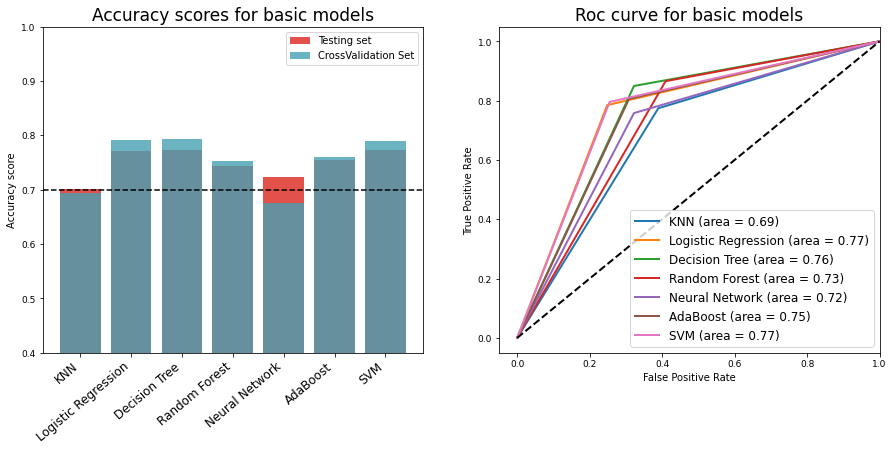

In [862]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Grafico a barre : Si creano due liste scores_all e scores_predictive che contengono i punteggi di accuratezza (accuracy scores) ottenuti durante la cross-validation (scores_all) e sui dati di testing (scores_predictive) per ciascun modello.

Si crea un grafico a barre (ax1) che rappresenta i punteggi di accuratezza per tutti i modelli. Le barre "CrossValidation Set" sono tratteggiate ("hatch="x"") e di un colore specifico, mentre le barre "Testing set" sono trasparenti (alpha=0.5) e di un colore diverso.

Curva ROC (Receiver Operating Characteristic): La curva ROC è una rappresentazione grafica delle prestazioni di un modello di classificazione binaria. Mostra la relazione tra la sensibilità (True Positive Rate o TPR) e la specificità (True Negative Rate o TNR) del modello al variare della soglia di decisione. In pratica, la curva ROC mostra come il modello si comporta nella distinzione tra classi positive e negative al variare della soglia. Idealmente, un modello con prestazioni eccellenti avrà una curva ROC che si avvicina al vertice in alto a sinistra del grafico, il che significa una sensibilità elevata e una specificità elevata.

AUC (Area Under the Curve): L'AUC è l'area sottesa alla curva ROC ed è una misura numerica delle prestazioni di un modello di classificazione binaria. L'AUC è compreso tra 0 e 1, dove un valore maggiore indica prestazioni migliori. Un'AUC pari a 1 indica che il modello è in grado di distinguere perfettamente tra classi positive e negative. Un'AUC pari a 0.5 indica che il modello non è migliore di una scelta casuale tra le classi.

Quindi, quando si dice "che mostra le curve ROC e le AUC dei modelli per valutare le loro prestazioni", si sta descrivendo un processo di valutazione delle prestazioni dei modelli di classificazione. Le curve ROC consentono di visualizzare come i modelli si comportano in termini di trade-off tra sensibilità e specificità, mentre l'AUC fornisce un valore numerico che riassume le prestazioni complessive del modello. Un AUC maggiore di 0.5 indica una performance migliore rispetto a un modello casuale, mentre un AUC di 1 indica una performance perfetta. Queste metriche sono spesso utilizzate per confrontare e valutare i modelli di classificazione binaria.

B)Relationship between genetic attributes and outcomes¶

Gli attributi genetici si riferiscono a caratteristiche o tratti che sono influenzati o determinati dal materiale genetico di un individuo. Questo materiale genetico è costituito dal DNA (acido desossiribonucleico) che si trova all'interno delle cellule e contiene le istruzioni per la formazione e il funzionamento di un organismo.
Gli attributi genetici possono influenzare la predisposizione di un individuo a determinate malattie o condizioni mediche. Alcuni esempi includono la suscettibilità a malattie ereditarie come la fibrosi cistica o la talassemia.
Gli attributi genetici sono influenzati dall'interazione tra i geni ereditati dai genitori di un individuo e da fattori ambientali. È importante notare che gli attributi genetici non sono determinati esclusivamente dal DNA, ma possono essere modulati da vari fattori esterni come l'ambiente, lo stile di vita e l'esposizione a fattori di rischio.


In [707]:
df.shape[:]

(1424, 692)

In [775]:
#  Eliminiamo le mutazioni
genetic_features_to_drop = df.columns[519:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
# Eliminiamo i clinical data
genetic_features_to_drop = genetic_df.columns[1:30]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)

#genetic_df = genetic_df.iloc [:,:-174]
genetic_df['overall_survival']= df['overall_survival']
genetic_df

patient_id   brca1   brca2   palb2    pten    tp53     atm    cdh1  \
0              0 -1.3990 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348   
1              2 -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594   
2              5  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398   
3              6  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491   
4              8  1.2932 -0.9039 -0.7219  0.2168  0.3484  0.3897  0.9131   
...          ...     ...     ...     ...     ...     ...     ...     ...   
1897        7293 -1.0694 -0.1392  0.7629  0.2124 -1.0129  0.1732  0.4767   
1898        7294  0.9244 -0.8580 -0.6622  1.4311 -1.3367 -0.0613  0.3168   
1899        7295  0.1563  0.5543 -0.6149  0.4572  1.3822 -0.0537 -0.1323   
1900        7296  0.1343  0.9128  1.3017  0.7383  0.1841  0.0028  0.1243   
1901        7297  1.8107 -0.2608  0.4006 -0.2985  0.0356 -0.1620  1.5486   

       chek2     nbn  ...  srd5a2  srd5a3     st7    star    tnk2   tulp4  \
0     0.1266 -0.8361  ... -0.0194 -1.6345 -0.2142 -0.5698 -1.1741 -1.4779   
1     0.7961  0.5419  ...  0.4534  0.4068  0.7634  0.0231  0.9121 -0.9538   
2     0.4187 -0.4030  ...  0.0668  0.8344  1.7227  0.4024 -3.7172 -1.5538   
3    -1.1889 -0.4174  ... -0.7078  0.8228  0.6819 -0.1948 -2.3286 -0.9924   
4     0.9356  0.7675  ... -0.3544 -1.0150  2.2961  0.1817 -0.1572  0.0427   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1897  0.0841 -0.7502  ... -0.1064  0.5544 -0.1777  1.4395 -1.7915 -0.2462   
1898  0.9005 -1.5454  ...  0.8212  0.2662  2.8345 -0.4319 -1.4772 -1.4477   
1899  0.2837 -0.0726  ...  1.5304  1.1196  0.8116  0.0958 -1.2644 -0.3566   
1900  2.2040 -0.6190  ... -0.6610 -0.1610  0.2251  0.5127 -0.3412 -1.0703   
1901  1.5309 -1.3653  ... -0.5194  2.3968  0.5917 -0.8643 -1.3541 -1.8076   

      ugt2b15  ugt2b17  ugt2b7  overall_survival  
0     -0.5954  -0.8847 -0.3354                 1  
1     -0.2264   0.5398 -0.8920                 1  
2      1.3701  -0.1078  0.3655                 0  
3     -0.3154   0.2320 -0.4828                 1  
4      5.0048   3.8476  1.3223                 0  
...       ...      ...     ...               ...  
1897  -0.2934   0.1854 -0.6448                 1  
1898  -0.1200  -0.6573 -0.5130                 0  
1899  -0.2615  -0.6371 -0.5540                 1  
1900  -0.6950   0.0641 -0.8863                 0  
1901  -0.1840   0.0967 -0.6264                 0  

[1424 rows x 491 columns]

In [709]:
genetic_df.shape[:]

(1424, 491)

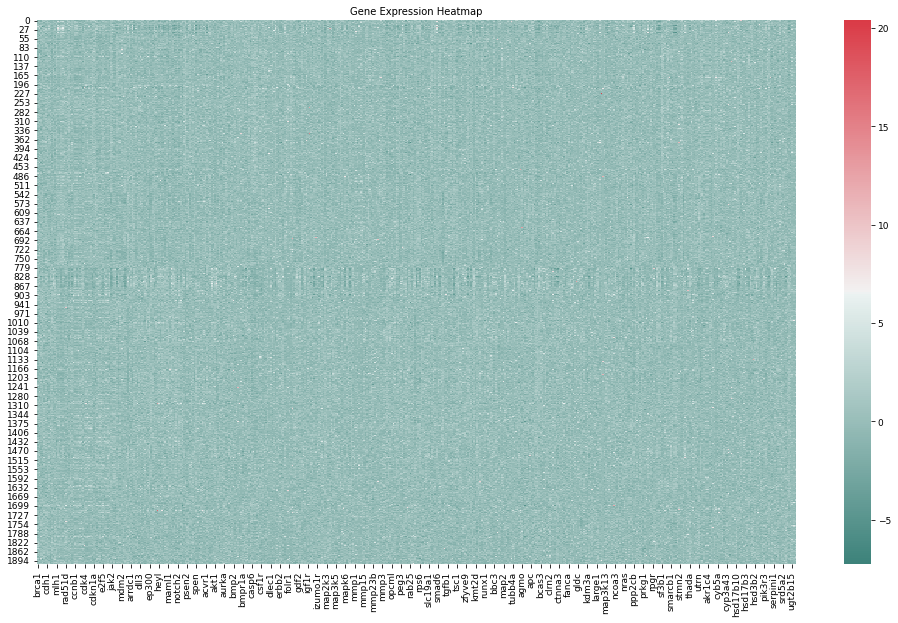

In [710]:
# Visualizing the mRNA values in a heatmap.
fig, axs = plt.subplots(figsize = (17, 10))
sns.heatmap(genetic_df.drop(['patient_id','overall_survival'], axis=1), ax = axs, cmap = sns.diverging_palette(180, 10, as_cmap = True))
plt.title('Gene Expression Heatmap')

plt.show()

TP53, ATM e CDH1 sono geni umani che svolgono importanti ruoli nel normale funzionamento delle cellule e possono essere associati a malattie o condizioni genetiche specifiche.

TP53: TP53, noto anche come gene p53, è un gene supressore dei tumori che svolge un ruolo chiave nella prevenzione della crescita tumorale. È coinvolto nella regolazione del ciclo cellulare, riparazione del DNA e apoptosi (morte cellulare programmata). Le mutazioni nel gene TP53 sono associate a una predisposizione ereditaria ai tumori, come la sindrome di Li-Fraumeni, e sono comuni in molti tipi di cancro.

ATM: ATM (Ataxia Telangiectasia Mutated) è un gene coinvolto nella riparazione del DNA e nella regolazione delle risposte cellulari allo stress da danni al DNA. Le mutazioni nel gene ATM sono associate alla sindrome di Atassia Telangiectasia (AT), una malattia genetica rara caratterizzata da disturbi neurologici, compromissione del sistema immunitario e una maggiore suscettibilità al cancro.

CDH1: CDH1 è il gene che codifica la proteina E-caderina, che è coinvolta nella coesione cellulare e nell'adesione tra le cellule epiteliali. Mutazioni nel gene CDH1 sono associate a una condizione chiamata sindrome di ereditaria di carcinoma lobulare del seno (HDGC, Hereditary Diffuse Gastric Cancer). Questa sindrome aumenta il rischio di sviluppare il carcinoma lobulare del seno e il carcinoma gastrico diffuso.

CHEK2: CHEK2 (Checkpoint kinase 2) è un gene coinvolto nella regolazione del ciclo cellulare e nella risposta al DNA danneggiato. Mutazioni nel gene CHEK2 possono essere associate ad un aumentato rischio di sviluppare il cancro al seno, al colon, alla prostata e ad altri tipi di tumori.

NBN: NBN (Nibrin) è un gene coinvolto nella riparazione del DNA e nella stabilità genomica. Mutazioni nel gene NBN possono essere associate alla sindrome di Nijmegen, una malattia genetica rara caratterizzata da anomalie dello sviluppo, immunodeficienza e un aumentato rischio di cancro.

NF1: NF1 (Neurofibromin 1) è un gene che produce la proteina neurofibromina, coinvolta nella regolazione della crescita delle cellule nervose. Mutazioni nel gene NF1 sono associate alla neurofibromatosi di tipo 1 (NF1), una malattia genetica che causa la formazione di tumori benigni sulla pelle e nel sistema nervoso.

STK11: STK11 (Serine/Threonine Kinase 11), noto anche come gene LKB1, è coinvolto nella regolazione del ciclo cellulare e nella supressione tumorale. Mutazioni nel gene STK11 sono associate alla sindrome di Peutz-Jeghers (PJS), una condizione caratterizzata dalla formazione di polipi intestinali e la predisposizione a tumori benigni e maligni in diverse parti del corpo.

BARD1: BARD1 (BRCA1 Associated RING Domain 1) è un gene coinvolto nella riparazione del DNA e nella regolazione della crescita cellulare. È associato al gene BRCA1 ed è coinvolto nel mantenimento della stabilità genomica. Mutazioni nel gene BARD1 possono essere associate a un aumentato rischio di sviluppare il cancro al seno e all'ovaio.

MLH1: MLH1 (MutL Homolog 1) è un gene coinvolto nella riparazione del DNA e nella stabilità genomica. È coinvolto nel processo di correzione degli errori del DNA durante la replicazione cellulare. Mutazioni nel gene MLH1 sono associate alla sindrome di Lynch, una condizione ereditaria che aumenta il rischio di sviluppare tumori del colon, dell'utero e di altri organi.

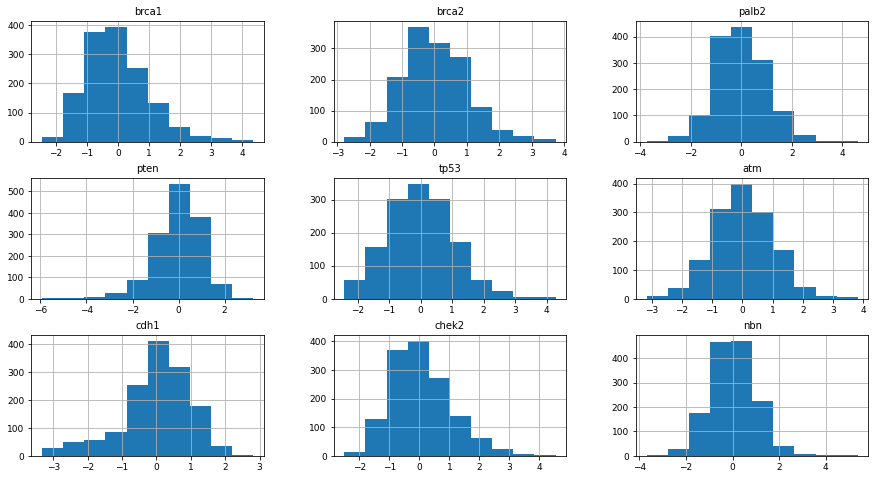

In [711]:
params = {'axes.titlesize':'10',
          'xtick.labelsize':'9',
          'ytick.labelsize':'9'}
matplotlib.rcParams.update(params)
#plt.subplots_adjust(hspace=0.5)
genetic_df.drop(['patient_id','overall_survival'], axis=1).iloc[:,:9].hist(figsize=(15,8))
plt.show()

#Gli istogrammi rappresentano la distribuzione dei valori all'interno di ciascuna colonna selezionata.
#L'asse x dell'istogramma rappresenta gli intervalli di valori per la colonna selezionata,
#mentre l'asse y rappresenta la frequenza di occorrenza di valori all'interno di ciascun intervallo.
#Quindi, per ciascuna delle colonne specificate, verrà visualizzato un istogramma che mostra come i
#valori sono distribuiti all'interno di quella colonna specifica. Questo può fornire informazioni
#sulla variabilità, la concentrazione o la forma della distribuzione dei valori per ciascuna colonna.



/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

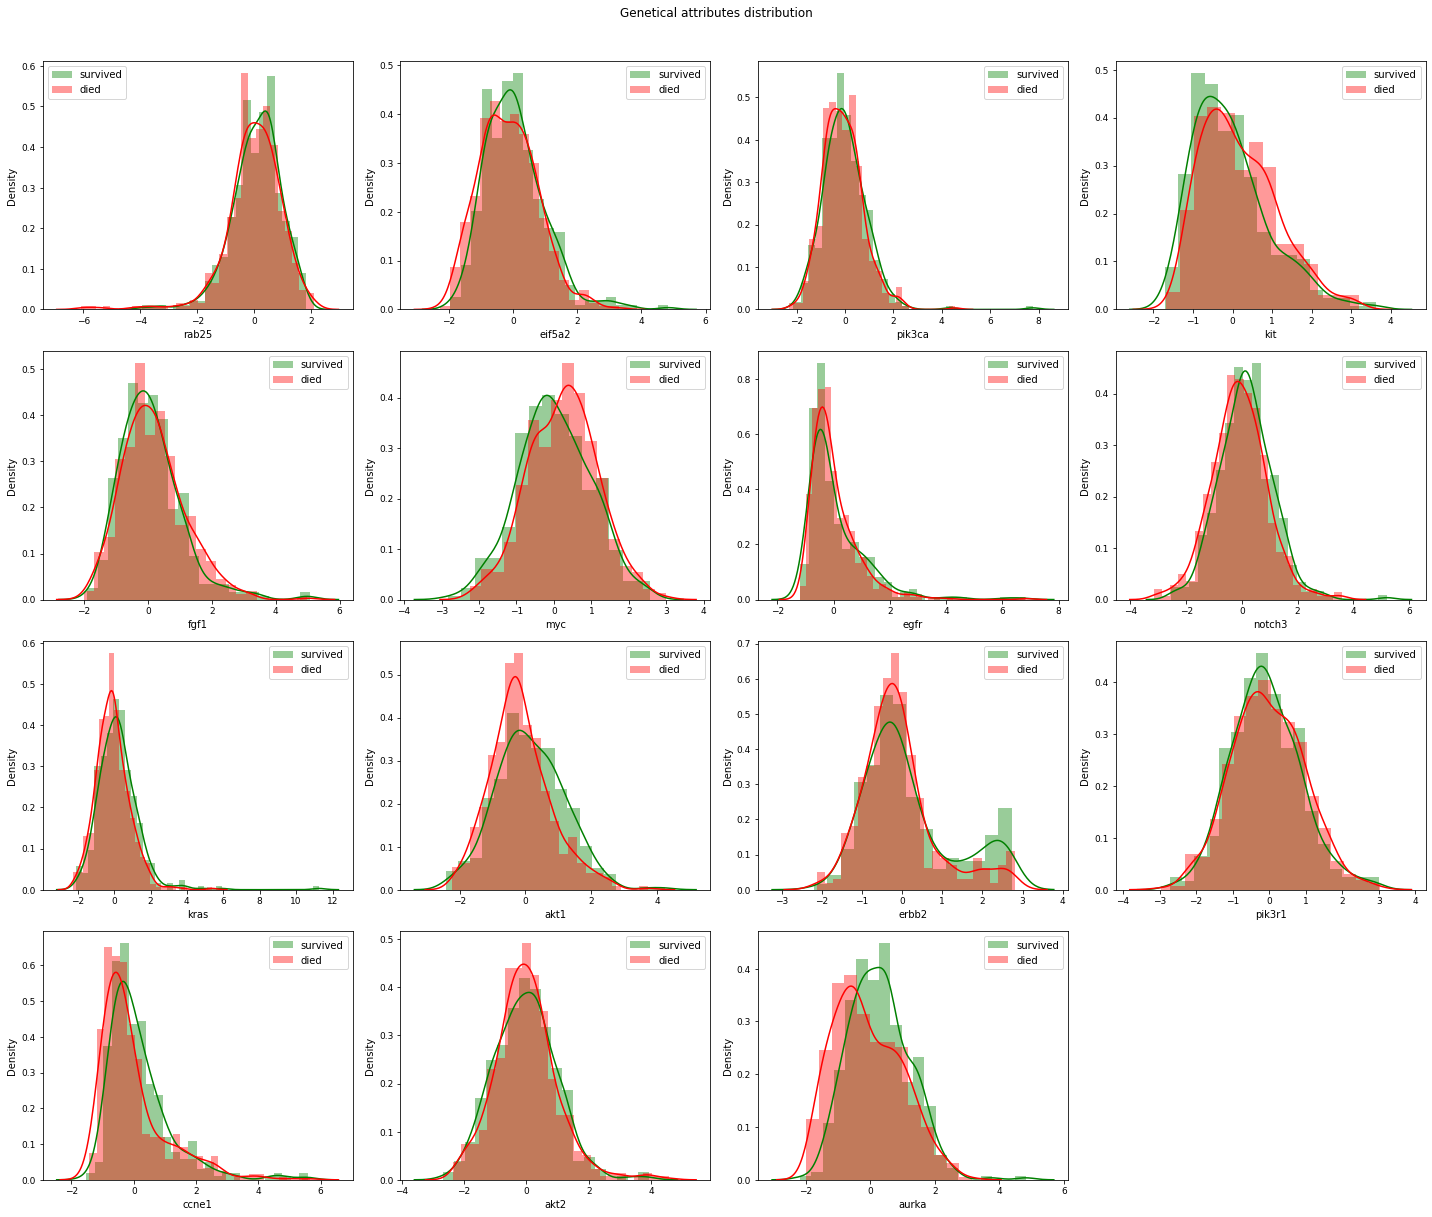

In [576]:
fig = plt.figure(figsize = (20, 25))
j = 0

gene_list = ['rab25', 'eif5a2', 'pik3ca', 'kit', 'fgf1', 'myc', 'egfr', 'notch3', 'kras', 'akt1', 'erbb2', 'pik3r1', 'ccne1', 'akt2', 'aurka']
for i in genetic_df.drop(['patient_id'], axis=1).loc[:,gene_list].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==0], color='g', label = 'survived')
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==1], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Genetical attributes distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()



All of the attributes have relatively the same distribution shape for two classes (survival and dead)


Text(0.5, 1.0, 'Histogram of Correlation of genes with the survival')

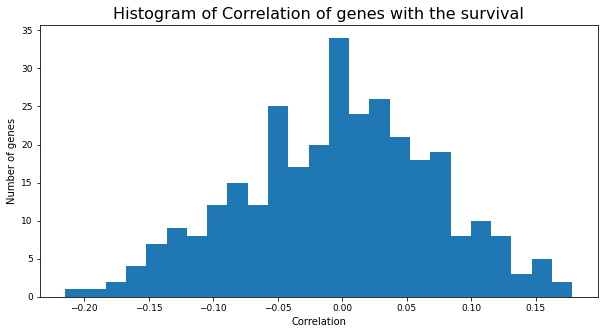

In [577]:
#quanto sono vari i geni e quanto bene si correlano con gli eventi di morte?
fig, ax = plt.subplots(figsize = (10,5))
#traccia l'istogramma della variazione utilizzando la deviazione standard come misura
corrs=[]
for col in genetic_df.drop(['patient_id'], axis = 1).columns:
    corr = genetic_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)
    #['overall_survival'][col]: Successivamente, viene utilizzata la doppia indicizzazione
    #per estrarre il valore specifico di correlazione tra le due colonne.
     #['overall_survival'] indica che stiamo selezionando la riga corrispondente alla colonna
     #'overall_survival' dalla matrice di correlazione.[col] indica che stiamo selezionando la
     #colonna specifica, che rappresenta il gene corrente, dalla riga selezionata.

corrs.pop(-1)
ax.hist(corrs,  bins=25)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)
# L'asse x dell'istogramma rappresenta i valori di correlazione con la sopravvivenza,
#mentre l'asse y rappresenta il numero di geni che presentano una determinata correlazione.
#Questo può fornire un'indicazione della variazione dei geni e della loro associazione
#con l'evento di sopravvivenza.

La maggior parte degli attributi ha una correlazione molto debole con gli attributi target

Classification with only genetic attributes




In [776]:
# data splitting
X = genetic_df.drop(['overall_survival'], axis=1)
y = genetic_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, stratify = y, random_state = 42)

In [777]:
X_train.shape[:] #ho 312 features

(1068, 490)

In [842]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo ma con RandomizedSearchCV)
print("LOGISTIC REGRESSION")
params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,4,25),
    "solver" : ["liblinear"]
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 100 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^4.

logistic_regression = RandomizedSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, n_jobs=-1, cv=4)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
#Early Stopping: Utilizza l'early stopping per interrompere l'addestramento quando le prestazioni sul set di validazione smettono di migliorare. Questo può evitare che il modello continui ad adattarsi eccessivamente.
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5, 3), max_iter=10000, random_state=42, early_stopping=True), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train.values, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25],
    "weights" : ["uniform" , "distance"],
    "p":[1,2]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42, max_depth = 3, max_leaf_nodes = 5)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
base_classifier = tree.DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=10, random_state=42, learning_rate=0.1)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(penalty='l1',dual=False, C = 0.2, max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.58801498 0.57303371 0.63670412 0.57303371]
CV Standard Deviation:  0.026133493889424854
CV Mean score:  0.5926966292134831

Train score:  0.6797752808988764
Test score/Accuratezza del modello:  0.6544943820224719

Precision: 0.6824644549763034
Recall: 0.72
Matrice di confusione :
[[ 89  67]
 [ 56 144]]

DECISION TREE
CV scores:  [0.58801498 0.51310861 0.6329588  0.58426966]
CV Standard Deviation:  0.042897794715188405
CV Mean score:  0.5795880149812734

Train score:  0.6713483146067416
Test score/Accuratezza del modello:  0.5870786516853933

Precision: 0.6007604562737643
Recall: 0.79
Matrice di confusione :
[[ 51 105]
 [ 42 158]]

NEURAL NETWORK


/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/danielep

CV scores:  [0.61797753 0.58052434 0.57303371 0.65917603]
CV Standard Deviation:  0.03426249899537825
CV Mean score:  0.6076779026217227

Train score:  0.6348314606741573
Test score/Accuratezza del modello:  0.598314606741573

Precision: 0.6233766233766234
Recall: 0.72
Matrice di confusione :
[[ 69  87]
 [ 56 144]]

KNN
CV scores:  [0.61797753 0.58052434 0.62172285 0.58801498]
CV Standard Deviation:  0.018034981539567615
CV Mean score:  0.6020599250936329

Train score:  1.0
Test score/Accuratezza del modello:  0.6039325842696629

Precision: 0.604982206405694
Recall: 0.85
Matrice di confusione :
[[ 45 111]
 [ 30 170]]

RANDOM FOREST
CV scores:  [0.63670412 0.58801498 0.64044944 0.5917603 ]
CV Standard Deviation:  0.02441648840899869
CV Mean score:  0.6142322097378278

Train score:  0.6966292134831461
Test score/Accuratezza del modello:  0.6179775280898876

Precision: 0.6194029850746269
Recall: 0.83
Matrice di confusione :
[[ 54 102]
 [ 34 166]]

ADABOOST
CV scores:  [0.6329588  0.595505

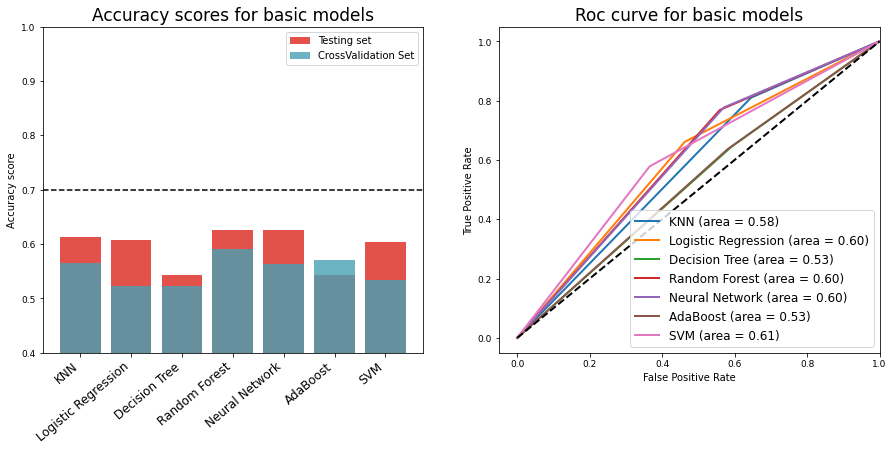

In [665]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

C) Mutazione dei geni


            Unique Mutations
patient_id              1424
tp53_mut                 288
muc16_mut                225
ahnak2_mut               187
kmt2c_mut                155
syne1_mut                151
pik3ca_mut               125
map3k1_mut               123
dnah11_mut               122
ahnak_mut                116


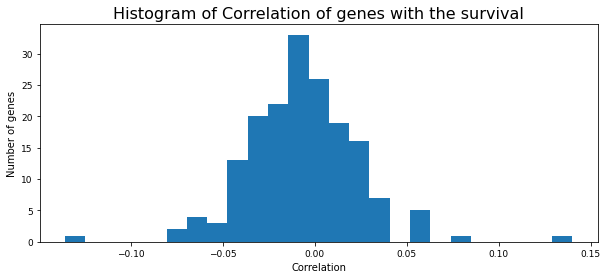

In [863]:
#Per avere solo le colonne che riguardano le mutazioni
#Drop columns that are not related to mutations
mutation_df_to_drop = df.columns[1:519]
mutation_df = df.drop(mutation_df_to_drop, axis = 1)

#Make a new dataframe with the unique counts of each mutation and sort
dfGroupedUniqueMutations = pd.DataFrame({"Unique Mutations": mutation_df.nunique()})
print(dfGroupedUniqueMutations.sort_values(by='Unique Mutations', ascending=False).head(10))


#Make dataframe of binary values for each gene (mutated = 1, not-mutated = 0)
mutation_df = mutation_df.applymap(lambda x: 1 if x != '0' else 0)
mutation_df.insert(loc=1 , column='overall_survival', value=df['overall_survival'])
mutation_df.head()

fig, ax = plt.subplots(figsize=(10,4))
corrs=[]
for col in mutation_df.drop(['patient_id'], axis = 1).columns:
    corr = mutation_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)

corrs.pop(0)
ax.hist(corrs,  bins=25)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)


plt.show()

The genes with the most varied mutations were:

tp53
muc16
syne1
pik3ca
map3k1
ahnak2
kmt2c
gata3
cdh1
dnah11

Nessuna correlazione tra sopravvivenza e mutazioni, poiché abbiamo cambiato la mutazione in 0 e 1 invece di 0 se non ci sono mutazioni e il tipo di mutazione se c'è una mutazione. Possiamo escludere per la modellazione finale.

<AxesSubplot:>

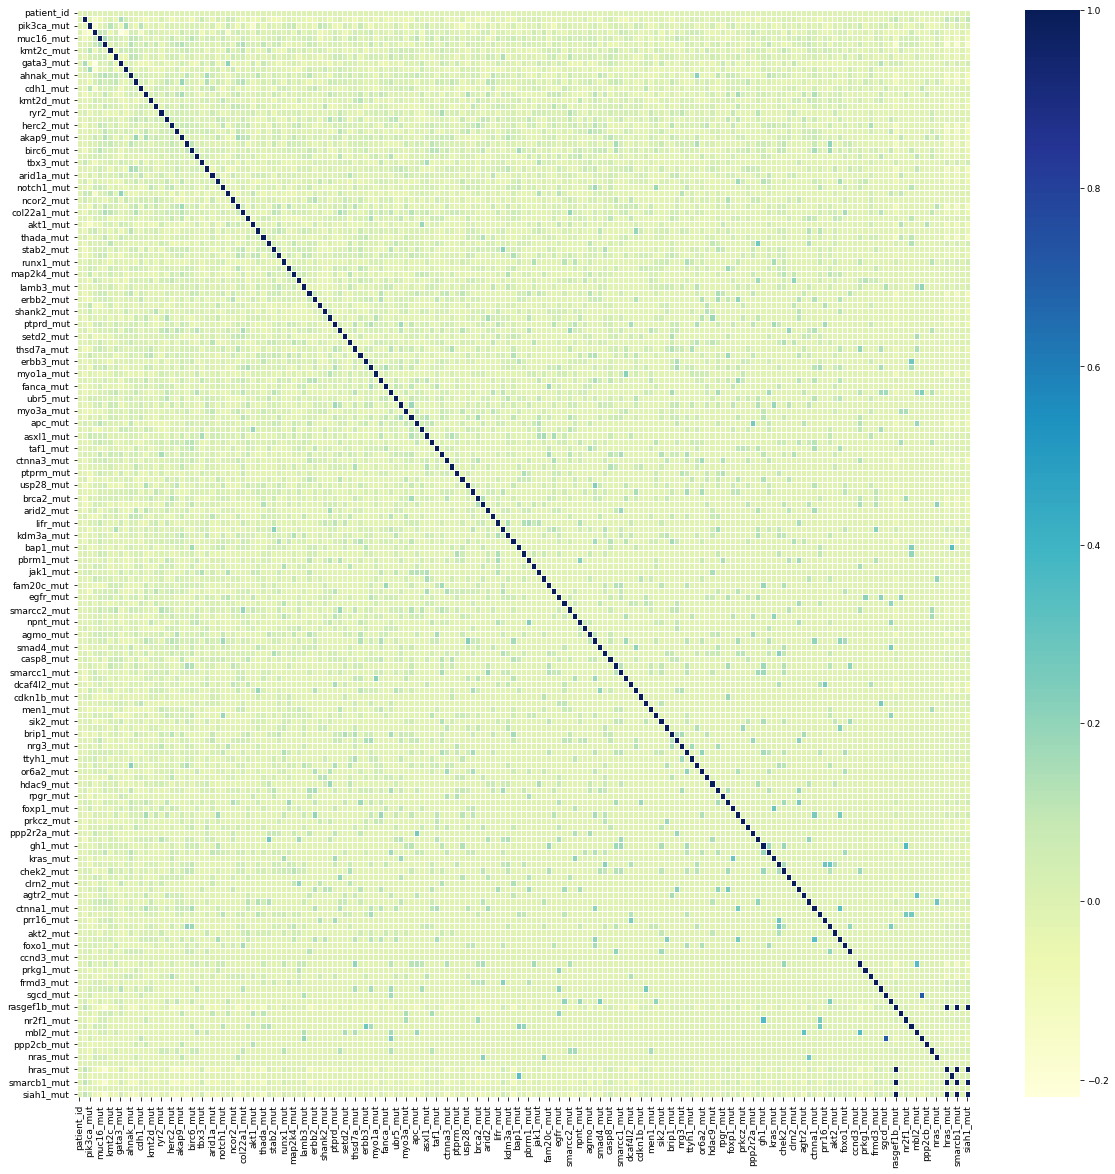

In [599]:
plt.figure(figsize=(20,20))
corr = mutation_df.corr().fillna(0)
sns.heatmap(corr, cmap = "YlGnBu", linewidths=0.5)

In [600]:
#The argsort returns indexes and columns from 0:len(columns),
#sorted in descending order by column values
#corr.values restituisce la rappresentazione della matrice di correlazione
#corr come un array NumPy.
#L'operazione -corr.values nega tutti i valori della matrice,
#invertendo l'ordine di ordinamento in modo che l'ordinamento venga
#eseguito in modo decrescente invece che crescente.
#np.argsort(-corr.values, axis=1) applica l'ordinamento decrescente alle
#colonne della matrice di correlazione corr e restituisce un array di indici
#che corrispondono all'ordine delle colonne in base alla loro correlazione decrescente.
#Gli indici nell'array arr corrispondono all'ordine delle colonne di corr in
#base alla loro correlazione decrescente. Ad esempio, arr[0] restituirà un
#array di indici che indica l'ordine delle colonne di corr in base alla
#correlazione più alta.
arr = np.argsort(-corr.values, axis=1)


#Il codice corr.apply(lambda row: row.nlargest(2).values[-1], axis=1)
#viene utilizzato per calcolare una nuova serie di dati chiamata corrValue
#che contiene il secondo valore più grande per ogni riga nella matrice di
#correlazione corr.
#Ecco una spiegazione passo-passo di come funziona il codice:
#corr è un DataFrame che rappresenta una matrice di correlazione tra le colonne di un dataset.
#corr.apply() viene utilizzato per applicare una funzione a ciascuna riga
#o colonna del DataFrame corr.
#lambda row: row.nlargest(2).values[-1] è una funzione lambda che prende
#in input una riga del DataFrame corr e restituisce il secondo valore più
#grande di quella riga.
#row.nlargest(2) seleziona i due valori più grandi nella riga.
#.values[-1] estrae l'ultimo valore tra i due valori più grandi,
#che rappresenta il secondo valore più grande.
#axis=1 specifica che la funzione lambda deve essere applicata lungo le righe del DataFrame corr.

corrValue = corr.apply(lambda row: row.nlargest(2).values[-1],axis=1)
#Qui creiamo un nuovo dataframe che ha come valori per ogni gene, il secondo
#gene con la correlazione maggiore (perchè il primo è se stesso) infatti se metto arr[:,0] ottengo lo stesso gene

dfUniqueMutationsBinary = pd.DataFrame({'Correlated Mutation': corr.columns[arr[:,1]], 'Pearson Correlation': corrValue}, index=corr.index)

bestMutation = dfUniqueMutationsBinary.sort_values(by = 'Pearson Correlation', ascending=False)
bestMutation.head(50)

Correlated Mutation  Pearson Correlation
siah1_mut            smarcb1_mut             1.000000
smarcb1_mut          smarcb1_mut             1.000000
hras_mut             smarcb1_mut             1.000000
rasgef1b_mut           siah1_mut             0.997377
sgcd_mut                mtap_mut             0.706692
mtap_mut                sgcd_mut             0.706692
nr2f1_mut                gh1_mut             0.351476
gh1_mut                nr2f1_mut             0.351476
nr3c1_mut               mbl2_mut             0.351476
mbl2_mut               nr3c1_mut             0.351476
bap1_mut               prps2_mut             0.331767
prps2_mut               bap1_mut             0.331767
ctnna1_mut              braf_mut             0.330983
braf_mut              ctnna1_mut             0.330983
agtr2_mut               mbl2_mut             0.313811
cdkn2a_mut              nras_mut             0.285959
nras_mut              cdkn2a_mut             0.285959
nf2_mut                prr16_mut             0.285959
prr16_mut                nf2_mut             0.285959
kras_mut               foxp1_mut             0.285959
foxp1_mut               kras_mut             0.285959
dtwd2_mut                nf2_mut             0.282881
erbb3_mut              klrg1_mut             0.278999
klrg1_mut              erbb3_mut             0.278999
ncor1_mut              prkce_mut             0.271201
prkce_mut              ncor1_mut             0.271201
gps2_mut               smad2_mut             0.264274
smad2_mut               gps2_mut             0.264274
magea8_mut             nr2f1_mut             0.264274
ppp2r2a_mut              apc_mut             0.261256
apc_mut              ppp2r2a_mut             0.261256
clk3_mut                braf_mut             0.254858
acvrl1_mut            large1_mut             0.254858
large1_mut            acvrl1_mut             0.254858
dcaf4l2_mut            prr16_mut             0.246762
smad4_mut             spaca1_mut             0.246762
spaca1_mut             smad4_mut             0.246762
adgra2_mut              mtap_mut             0.233342
ptpn22_mut              braf_mut             0.231957
npnt_mut               pbrm1_mut             0.230591
pbrm1_mut               npnt_mut             0.230591
zfp36l1_mut            usp28_mut             0.226071
usp28_mut            zfp36l1_mut             0.226071
sik1_mut                 nf2_mut             0.218547
sbno1_mut              stab2_mut             0.217040
stab2_mut              sbno1_mut             0.217040
palld_mut              myo1a_mut             0.216181
myo1a_mut              palld_mut             0.216181
frmd3_mut              sbno1_mut             0.215791
ahnak_mut              taf4b_mut             0.214526

Provo a fare i test

In [864]:
columns_to_drop = ['overall_survival', 'hras_mut','rasgef1b_mut', 'smarcb1_mut']
X = mutation_df.drop(columns_to_drop, axis = 1)
y = mutation_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

In [899]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo ma con RandomizedSearchCV)
print("LOGISTIC REGRESSION")
params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,3,25),
    "solver" : ["liblinear"]
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 25 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^3.

logistic_regression = RandomizedSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, n_jobs=-1, cv=4)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
#Early Stopping: Utilizza l'early stopping per interrompere l'addestramento quando le prestazioni sul set di validazione smettono di migliorare. Questo può evitare che il modello continui ad adattarsi eccessivamente.
MLP_clf = GridSearchCV(MLPClassifier(alpha=0.01, hidden_layer_sizes=(7,5,3), max_iter=10000, random_state=42, early_stopping=True), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train.values, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,40],
    "weights" : ["uniform" , "distance"],
    "p":[1,2]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
param_grid = {
    'n_estimators': [50, 100, 150],         # Numero di alberi nella foresta
    'max_depth': [None, 10, 20, 30],       # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Numero minimo di campioni richiesti per suddividere un nodo
    'min_samples_leaf': [1, 2, 4]          # Numero minimo di campioni richiesti in una foglia
}
cl_random_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=cl_random_forest, param_grid=param_grid, cv=4, n_jobs=-1)

rf_pred, rf_test, rf_train = metrics(grid_search, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(penalty='l1',dual=False, C = 0.2, max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.49438202 0.54681648 0.59925094 0.54681648]
CV Standard Deviation:  0.03707676006221598
CV Mean score:  0.5468164794007491

Train score:  0.6404494382022472
Test score/Accuratezza del modello:  0.6039325842696629

Precision: 0.6184738955823293
Recall: 0.77
Matrice di confusione :
[[ 61  95]
 [ 46 154]]

DECISION TREE
CV scores:  [0.53558052 0.53558052 0.60299625 0.61048689]
CV Standard Deviation:  0.035678949219583644
CV Mean score:  0.5711610486891385

Train score:  0.6207865168539326
Test score/Accuratezza del modello:  0.5758426966292135

Precision: 0.5782747603833865
Recall: 0.905
Matrice di confusione :
[[ 24 132]
 [ 19 181]]

NEURAL NETWORK
CV scores:  [0.48689139 0.56554307 0.56554307 0.47191011]
CV Standard Deviation:  0.043395618824930614
CV Mean score:  0.5224719101123596

Train score:  0.5440074906367042
Test score/Accuratezza del modello:  0.5449438202247191

Precision: 0.5913461538461539
Recall: 0.615
Matrice di confusione :
[[ 71  85]
 [ 

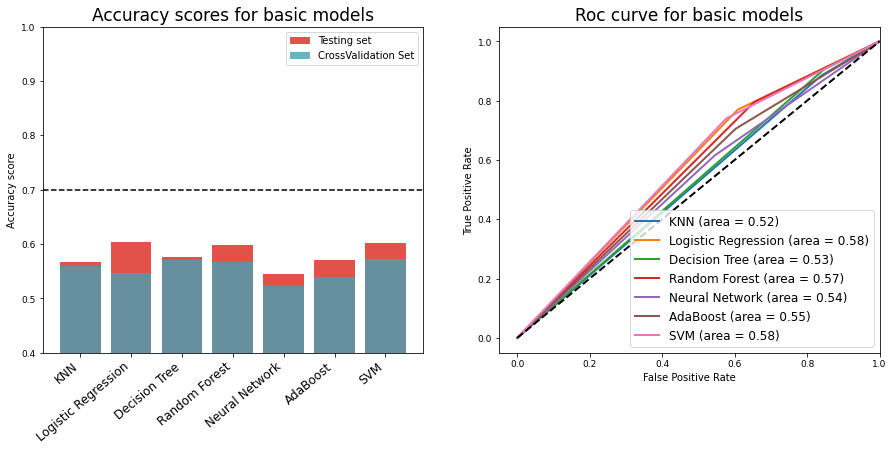

In [900]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Classificazione con solo attributi clinici e genetici

In [901]:
features_to_drop = df.columns[519:]
df_all = df.drop(features_to_drop, axis = 1)
df_all = df_all.drop("death_from_cancer", axis = 1)
#df_all = df_all.drop("overall_survival_months", axis = 1)
all_categorical_columns = df_all.select_dtypes(include=['object']).columns.tolist()
dummies_df = pd.get_dummies(df_all.drop('patient_id',axis=1 ), columns= all_categorical_columns, dummy_na=True)
dummies_df.dropna(inplace = True)
dummies_df


age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
1                43.19             0     1.0                        3.0   
2                48.87             1     1.0                        2.0   
3                47.68             1     1.0                        2.0   
4                76.97             1     1.0                        3.0   
5                78.77             0     1.0                        3.0   
...                ...           ...     ...                        ...   
1897             56.90             0     4.0                        3.0   
1898             59.20             0     4.0                        2.0   
1899             43.10             0     4.0                        3.0   
1900             42.88             0     4.0                        3.0   
1901             62.90             0     4.0                        3.0   

      hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
1                   1                            0.0             2.0   
2                   1                            1.0             2.0   
3                   1                            3.0             1.0   
4                   1                            8.0             2.0   
5                   1                            0.0             4.0   
...               ...                            ...             ...   
1897                1                            1.0             5.0   
1898                1                            1.0             2.0   
1899                1                            1.0             4.0   
1900                0                            1.0             6.0   
1901                1                           45.0             4.0   

      nottingham_prognostic_index  overall_survival_months  overall_survival  \
1                           4.020                84.633333                 1   
2                           4.030               163.700000                 0   
3                           4.050               164.933333                 1   
4                           6.080                41.366667                 0   
5                           4.062                 7.800000                 0   
...                           ...                      ...               ...   
1897                        5.090               199.233333                 1   
1898                        4.030                82.733333                 0   
1899                        5.050               196.866667                 1   
1900                        5.040                44.733333                 0   
1901                        6.050               175.966667                 0   

      ...  oncotree_code_MDLC  oncotree_code_nan  pr_status_Negative  \
1     ...                   0                  0                   0   
2     ...                   0                  0                   0   
3     ...                   1                  0                   0   
4     ...                   1                  0                   0   
5     ...                   0                  0                   0   
...   ...                 ...                ...                 ...   
1897  ...                   0                  0                   0   
1898  ...                   0                  0                   0   
1899  ...                   0                  0                   0   
1900  ...                   0                  0                   1   
1901  ...                   0                  0                   0   

      pr_status_Positive  pr_status_nan  \
1                      1              0   
2                      1              0   
3                      1              0   
4                      1              0   
5                      1              0   
...                  ...            ...   
1897                   1              0   
1898                   1              0   
1899                   1   

In [902]:
# data splitting
X = dummies_df.drop( ['overall_survival'], axis=1)
y = dummies_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, random_state=42, stratify = y)

In [970]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo ma con RandomizedSearchCV)
print("LOGISTIC REGRESSION")
params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,4,100),
    "solver" : ["liblinear"]
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 100 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^4.

logistic_regression = RandomizedSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, n_jobs=-1, cv=4)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3, )
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
#Early Stopping: Utilizza l'early stopping per interrompere l'addestramento quando le prestazioni sul set di validazione smettono di migliorare. Questo può evitare che il modello continui ad adattarsi eccessivamente.
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=10000, random_state=42, early_stopping=True), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train.values, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,30,50, 100],
    "weights" : ["uniform" , "distance"],
    "p":[1,2]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42, max_depth = 5, max_leaf_nodes = 10, n_estimators = 50)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
base_classifier = tree.DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=25, random_state=42, learning_rate=0.3)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(penalty='l1',dual=False, C = 0.02, max_iter=10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.8247012  0.77689243 0.792      0.792     ]
CV Standard Deviation:  0.01746584464817374
CV Mean score:  0.796398406374502

Train score:  0.875249500998004
Test score/Accuratezza del modello:  0.7761194029850746

Precision: 0.7967914438502673
Recall: 0.8010752688172043
Matrice di confusione :
[[111  38]
 [ 37 149]]

DECISION TREE
CV scores:  [0.79282869 0.78884462 0.76       0.756     ]
CV Standard Deviation:  0.016539212402532363
CV Mean score:  0.7744183266932272

Train score:  0.8143712574850299
Test score/Accuratezza del modello:  0.7343283582089553

Precision: 0.7539267015706806
Recall: 0.7741935483870968
Matrice di confusione :
[[102  47]
 [ 42 144]]

NEURAL NETWORK
CV scores:  [0.61354582 0.5936255  0.616      0.544     ]
CV Standard Deviation:  0.028925303726383928
CV Mean score:  0.591792828685259

Train score:  0.7894211576846307
Test score/Accuratezza del modello:  0.6895522388059702

Precision: 0.7383720930232558
Recall: 0.6827956989247311
M

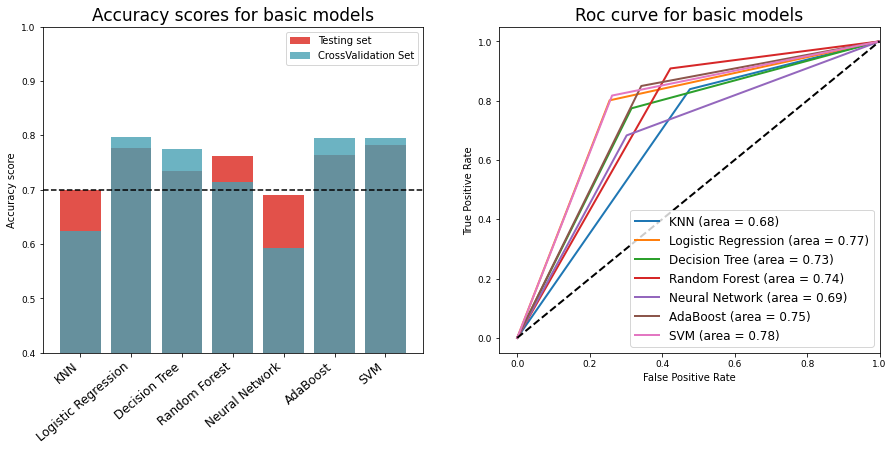

In [971]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Per effettuare una feature selection possiamo usare la 'Selezione basata su statistiche':
Utilizzare test statistici come l'ANOVA (Analysis of Variance) o il test chi-quadrato per valutare la rilevanza delle feature rispetto al target.
Scikit-learn fornisce la classe SelectKBest per selezionare le prime K feature basate su un test di significatività.
score_func=f_classif è un parametro utilizzato nella classe SelectKBest di scikit-learn per specificare quale funzione
di scoring o test statistico deve essere utilizzata per valutare la rilevanza delle feature nel contesto di una
classificazione (classification task). In questo caso, f_classif è una delle opzioni disponibili per il calcolo
del punteggio di rilevanza delle feature.

f_classif rappresenta il test F di ANOVA (Analysis of Variance), che è utilizzato per valutare se ci sono
differenze significative nelle medie dei valori delle feature tra le diverse classi o categorie di un problema di
classificazione. Il punteggio restituito da f_classif misura quanto le feature siano informative per distinguere
le diverse classi nel dataset.

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/sit

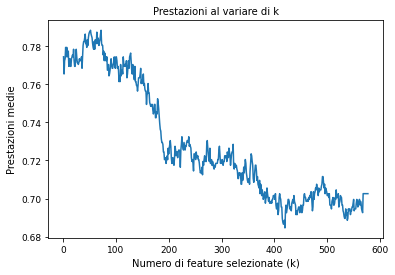

Best k:  52


In [972]:
k_values = range(1, len(X.columns))
scores = []

#Uso come classificatore:
#dec_tree_clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=42, max_iter=4000)
best_K = 0
max = 0

for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([('selector', selector), ('classifier', clf)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # Esempio di 5-fold cross-validation
    scores.append(cv_scores.mean())
    if(cv_scores.mean() > max):
      max = cv_scores.mean()
      best_K = k

plt.plot(k_values, scores)
plt.xlabel('Numero di feature selezionate (k)')
plt.ylabel('Prestazioni medie')
plt.title('Prestazioni al variare di k')
plt.show()
print("Best k: ", best_K)


In [973]:
selector = SelectKBest(score_func=f_classif, k=best_K)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [1018]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(penalty = 'l1', solver='liblinear', random_state=42, max_iter=4000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3, max_leaf_nodes = 10)
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42, max_depth = 5,  max_leaf_nodes = 10, n_estimators = 50)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
base_classifier = tree.DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=25, random_state=42, learning_rate=0.3)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter = 10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.83266932 0.812749   0.788      0.768     ]
CV Standard Deviation:  0.024481211347730278
CV Mean score:  0.8003545816733069

Train score:  0.8303393213572854
Test score/Accuratezza del modello:  0.7910447761194029

Precision: 0.8052631578947368
Recall: 0.8225806451612904
Matrice di confusione :
[[112  37]
 [ 33 153]]

DECISION TREE
CV scores:  [0.79282869 0.78884462 0.76       0.756     ]
CV Standard Deviation:  0.016539212402532363
CV Mean score:  0.7744183266932272

Train score:  0.8143712574850299
Test score/Accuratezza del modello:  0.7343283582089553

Precision: 0.7539267015706806
Recall: 0.7741935483870968
Matrice di confusione :
[[102  47]
 [ 42 144]]

NEURAL NETWORK
CV scores:  [0.80079681 0.78884462 0.748      0.76      ]
CV Standard Deviation:  0.021270627545911403
CV Mean score:  0.7744103585657369

Train score:  0.8662674650698603
Test score/Accuratezza del modello:  0.7970149253731343

Precision: 0.795
Recall: 0.8548387096774194
Matrice di

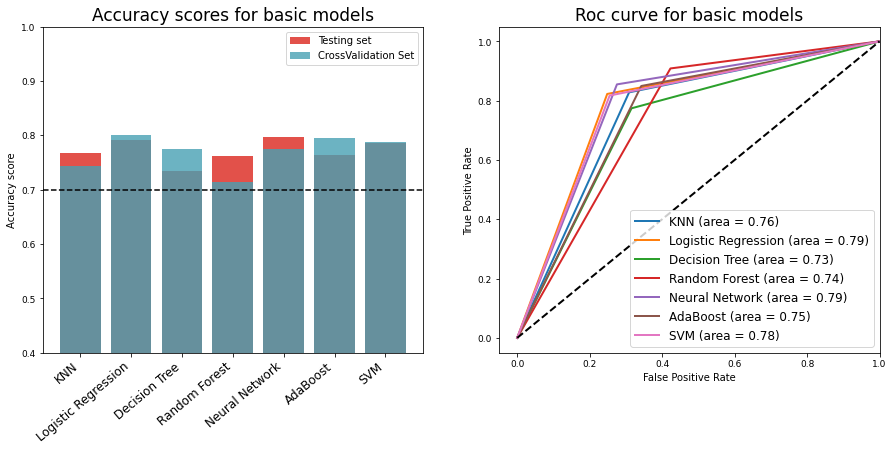

In [1019]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

CI SONO STATI NETTI MIGLIORAMENTI


In [752]:
#INVECE CON TUTTO IL DATASET INSIEME
columns_to_drop = ['hras_mut','siah1_mut', 'smarcb1_mut', "death_from_cancer"]
all_df = df.drop(columns_to_drop, axis = 1)
all_df.iloc[:, 518:] = all_df.iloc[:, 518:].applymap(lambda x: 1 if x != '0' else 0)

columns_object = all_df.select_dtypes(include = ['object']).columns.to_list()
dataset = pd.get_dummies(all_df.drop('patient_id',axis=1 ), columns = columns_object, dummy_na = False)
dataset.dropna(inplace = True)

X = dataset.drop("overall_survival", axis = 1)
y = dataset['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, random_state=42, stratify = y)


In [729]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(penalty = 'l1', solver='liblinear', random_state=42, max_iter=1000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
print("NEURAL NETWORK")
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 2000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train, X_test, y_train, y_test, 4)

#KNN
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.
print("KNN")
clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC()
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.72111554 0.70517928 0.712      0.704     ]
CV Standard Deviation:  0.006809514387871716
CV Mean score:  0.7105737051792829

Train score:  0.998003992015968
Test score/Accuratezza del modello:  0.7164179104477612

Precision: 0.7513812154696132
Recall: 0.7311827956989247
Matrice di confusione :
[[104  45]
 [ 50 136]]

DECISION TREE
CV scores:  [0.74900398 0.74103586 0.724      0.716     ]
CV Standard Deviation:  0.013131469268555965
CV Mean score:  0.7325099601593625

Train score:  1.0
Test score/Accuratezza del modello:  0.6895522388059702

Precision: 0.7383720930232558
Recall: 0.6827956989247311
Matrice di confusione :
[[104  45]
 [ 59 127]]

NEURAL NETWORK
CV scores:  [0.71713147 0.61354582 0.628      0.692     ]
CV Standard Deviation:  0.04313205113759311
CV Mean score:  0.6626693227091633

Train score:  1.0
Test score/Accuratezza del modello:  0.6776119402985075

Precision: 0.695
Recall: 0.7473118279569892
Matrice di confusione :
[[ 88  61]
 [ 47 1

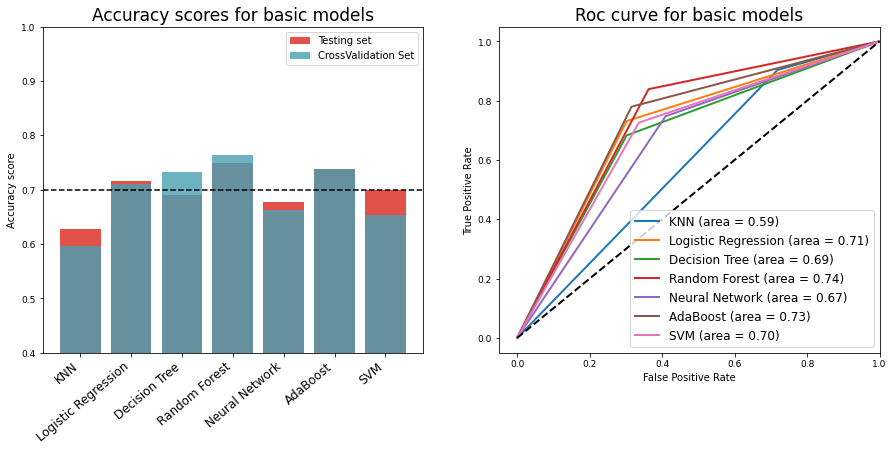

In [730]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [672 673] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [672 673] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: 

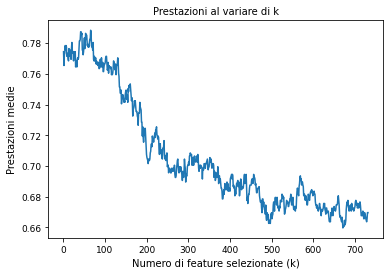

BEST K : 66


In [731]:

# Crea un grafico delle prestazioni per valori di k da 1 a al max num di features -1
k_values = range(1, len(X.columns))
scores = []

#Uso come classificatore:
#dec_tree_clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=42, max_iter=4000)

max = 0
best_k = 0
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([('selector', selector), ('classifier', clf)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # Esempio di 5-fold cross-validation
    scores.append(cv_scores.mean())
    if max < cv_scores.mean():
      max = cv_scores.mean()
      best_k = k

plt.plot(k_values, scores)
plt.xlabel('Numero di feature selezionate (k)')
plt.ylabel('Prestazioni medie')
plt.title('Prestazioni al variare di k')
plt.show()
print("BEST K :", best_k)


In [753]:
selector = SelectKBest(score_func=f_classif, k=best_k)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [672 673] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [733]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(penalty = 'l1', solver='liblinear', random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 20000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.812749   0.79282869 0.784      0.744     ]
CV Standard Deviation:  0.025014915631112626
CV Mean score:  0.783394422310757

Train score:  0.8303393213572854
Test score/Accuratezza del modello:  0.7820895522388059

Precision: 0.7810945273631841
Recall: 0.8440860215053764
Matrice di confusione :
[[105  44]
 [ 29 157]]

DECISION TREE
CV scores:  [0.71314741 0.7250996  0.704      0.684     ]
CV Standard Deviation:  0.015021800742509459
CV Mean score:  0.7065617529880479

Train score:  1.0
Test score/Accuratezza del modello:  0.6537313432835821

Precision: 0.7011494252873564
Recall: 0.6559139784946236
Matrice di confusione :
[[ 97  52]
 [ 64 122]]

NEURAL NETWORK
CV scores:  [0.70119522 0.812749   0.696      0.74      ]
CV Standard Deviation:  0.04666087477029997
CV Mean score:  0.7374860557768925

Train score:  0.8682634730538922
Test score/Accuratezza del modello:  0.808955223880597

Precision: 0.801980198019802
Recall: 0.8709677419354839
Matrice di confu

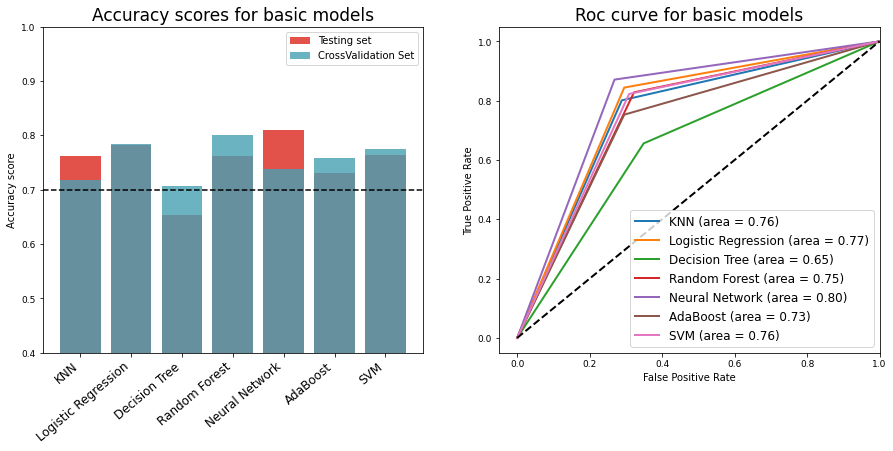

In [734]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)